# Import & Setup

##### Target Libraries

In [1]:
# Setup:
import eli5
import numpy as np
import pandas as pd
import streamlit as st

# Plot:
import matplotlib.pyplot as plt

# Machine Learning:
from catboost import CatBoostClassifier
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# Interpretation:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix, classification_report
import shap

In [2]:
# This code enables intellisense.
%config IPCompleter.greedy=True

In [3]:
# To display all columns and more rows.
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# This code is to ignore copy warnings.
pd.options.mode.chained_assignment = None

In [4]:
# This will set the style for all
# bar plots:
plt.style.use('default')

# Link for plt styles 'https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html'

##### Other Libraries

In [5]:
# For libraries needed not in target library section
import joblib
from datetime import datetime
from pandas_profiling import ProfileReport

##### Testing

In [6]:
# Just testing how to load a pickle file

# model_pkl = pd.read_pickle(r'randomforest_modelv1.pkl')
# model_pkl

In [7]:
# Just testing how to load a joblib file

# model_job = joblib.load('randomforest_model.joblib')
# model_pkl

# EDA

In [8]:
# Using the cleanest dataset from data exploration notebook
df = pd.read_csv('All_data_with_exits_cleaned.csv')

In [9]:
%%capture

# This create a pandas profile report and saves
# a html link in current directory.

# profile = ProfileReport(df, minimal=True)
# profile.to_file("Pandas Profile.html")

In [10]:
print("df shape:", df.shape)
df.head(5)

df shape: (1862, 70)


,Project Name,Relationship to HoH,CaseMembers,Enroll Date,Exit Date,Social Security Quality,Age at Enrollment,Race,Ethnicity,Gender,Veteran Status,Disabling Condition at Entry,Living Situation,Length of Stay,Homeless Start Date,Length of Time Homeless (Approximate Start),Times Homeless Last Years,Total Months Homeless Last Years,Last Permanent Address,State,Zip,Days Enrolled in Project,Housing Status,Covered by Health Insurance,Domestic Violence,Current Status (Retired Data Element),Connected to McKinney Vento Liason (Retired),Household Type,Last Grade Completed,School Status,Employed Status,Why Not Employed,Count of Bed Nights (Housing Check-ins),Date of Last ES Stay (Beta),Date of First ES Stay (Beta),Income Total at Entry,Income Total at Exit,Non-Cash Benefit Count,Non-Cash Benefit Count at Exit,Barrier Count at Entry,Under Years Old,Chronic Health Condition,Mental Health Problem,CaseChildren,CaseAdults,Other Public,State Funded,Indian Health Services (IHS),Other,Combined Childrens HealthInsurance/Medicaid,Medicaid,Medicare,State Children's health Insurance S-CHIP,Veteran's Administration Medical Services,Health Insurance obtained through COBRA,Private - Employer,Private,Private - Individual,Earned Income,Unemployment Insurance,Supplemental Security Income,Social Security Disability Income,VA Disability Compensation,Private Disability Income,Workers Compensation,TANF,General Assistance,Child Support,Other Income,Target Exit Destination
0,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Client Refused,4,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
1,FPS--ES--Bridges Family Shelter,Self,6,736582,736702,Full SSN,28,White,Non-Hispanic/Latino,Male,No,Missing,Hotel or motel paid for without emergency shel...,"One month or more, but less than 90 days",735538,1164.0,Three times,More than 12 months,Data not collected,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1300.0,NaN,0,0,1,No,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1300.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
2,FPS--ES--Bridges Family Shelter,Daughter,6,736582,736718,Client Refused,10,White,Non-Hispanic/Latino,Female,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,136,NaN,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
3,FPS--ES--Bridges Family Shelter,Son,6,736582,736702,Full SSN,5,White,Non-Hispanic/Latino,Male,NaN,No,NaN,Unknown,1,NaN,NaN,NaN,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,NaN,NaN,0,0,0,Yes,NaN,NaN,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other
4,FPS--ES--Bridges Family Shelter,Significant Other (Non-Married),6,736582,736702,Client Refused,27,White,Non-Hispanic/Latino,Female,No,Yes,Hotel or motel paid for without emergency shel...,Unknown,736212,490.0,NaN,More than 12 months,NaN,NaN,NaN,120,Category 1 - Homeless,Yes,NaN,NaN,NaN,Household with Adults and Children,NaN,NaN,NaN,NaN,0,1,1,1200.0,1600.0,1,0,2,No,NaN,Mental Illness,4,2,No,Yes,No,No,No,No,No,No,No,No,No,No,No,1200.0,0,0.0,0,0,0,0,0,0,0.0,0,Unknown/Other


# Wrangling

In [11]:
# Dropping the [other] column
# It shows no meaning
df = df.drop('Other', axis=1)

In [12]:
# Need ordinal dates to train models
# Useless code below for model interpretation:

# # Changing the ordinal dates into real world
# # datetime dates
# for i, dt in enumerate(df['Enroll Date']):
#     df['Enroll Date'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Exit Date']):
#     if dt == 1:
#         continue
#     df['Exit Date'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Homeless Start Date']):
#     if dt == 1:
#         continue
#     df['Homeless Start Date'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Date of Last ES Stay (Beta)']):
#     if dt == 1:
#         continue
#     df['Date of Last ES Stay (Beta)'][i] = datetime.fromordinal(dt)
    
# for i, dt in enumerate(df['Date of First ES Stay (Beta)']):
#     if dt == 1:
#         continue
#     df['Date of First ES Stay (Beta)'][i] = datetime.fromordinal(dt)

# # Replacing exit dates value of 1 to NaN
# df['Exit Date'] = df['Exit Date'].replace(1, np.nan)
# df['Homeless Start Date'] = df['Homeless Start Date'].replace(1, np.nan)
# df['Date of Last ES Stay (Beta)'] = df['Date of Last ES Stay (Beta)'].replace(1, np.nan)
# df['Date of First ES Stay (Beta)'] = df['Date of First ES Stay (Beta)'].replace(1, np.nan)

# # Changing the date columns in datetime format
# df['Enroll Date'] = pd.to_datetime(df['Enroll Date'])
# df['Exit Date'] = pd.to_datetime(df['Exit Date'])
# df['Homeless Start Date'] = pd.to_datetime(df['Homeless Start Date'])
# df['Date of Last ES Stay (Beta)'] = pd.to_datetime(df['Date of Last ES Stay (Beta)'])
# df['Date of First ES Stay (Beta)'] = pd.to_datetime(df['Date of First ES Stay (Beta)'])

##### Saving csv

In [13]:
# df.to_csv("../visuals/All_data_with_exits_cleaned_v2.csv", index=False)
# df[:500].to_csv("../visuals/All_data_with_exits_cleaned_demo_v2.csv", index=False)

# Split Data

In [14]:
target = 'Target Exit Destination'
X = df.drop(target, axis=1)
y = df[target]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80,
                                                    test_size=0.20, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75,
                                                  test_size=0.25, random_state=0)

# Sets Information

In [16]:
print("Training: 80%")
print("Validation: 20%")
print("Test: 20%")
print("")
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)
print("Test set shape: ", X_test.shape)

Training: 80%
Validation: 20%
Test: 20%

Training set shape:  (1116, 68)
Validation set shape:  (373, 68)
Test set shape:  (373, 68)


# Baseline

In [17]:
y.value_counts(normalize=True)

Unknown/Other           0.353921
Permanent Exit          0.317938
Emergency Shelter       0.209989
Temporary Exit          0.066058
Transitional Housing    0.052095
Name: Target Exit Destination, dtype: float64

# Models
- Encoded with `OrdinalEncoder`

#### Setup

In [18]:
processor = make_pipeline(OrdinalEncoder(), SimpleImputer())
X_train = processor.fit_transform(X_train)
X_val = processor.transform(X_val)
X_test = processor.transform(X_test)

encoded_cols = list(range(0, X.shape[1]))
column_names = list(X.columns)
features = dict(zip(encoded_cols, column_names))

## `CatBoostClassifier`

In [19]:
cat_model = CatBoostClassifier(iterations=5000, random_state=0)

cat_model.fit(X_train, y_train)

Learning rate set to 0.020423
0:	learn: 1.5998057	total: 51.8ms	remaining: 4m 19s
1:	learn: 1.5890332	total: 54.8ms	remaining: 2m 17s
2:	learn: 1.5816302	total: 58ms	remaining: 1m 36s
3:	learn: 1.5714659	total: 60.9ms	remaining: 1m 16s
4:	learn: 1.5609628	total: 64.3ms	remaining: 1m 4s
5:	learn: 1.5513015	total: 67.7ms	remaining: 56.4s
6:	learn: 1.5421370	total: 70.8ms	remaining: 50.5s
7:	learn: 1.5316794	total: 73.9ms	remaining: 46.1s
8:	learn: 1.5237737	total: 77.8ms	remaining: 43.1s
9:	learn: 1.5163300	total: 81ms	remaining: 40.4s
10:	learn: 1.5100552	total: 84.3ms	remaining: 38.2s
11:	learn: 1.5029124	total: 87.2ms	remaining: 36.3s
12:	learn: 1.4957559	total: 90.6ms	remaining: 34.7s
13:	learn: 1.4869410	total: 93.9ms	remaining: 33.4s
14:	learn: 1.4781698	total: 97.1ms	remaining: 32.3s
15:	learn: 1.4706507	total: 100ms	remaining: 31.2s
16:	learn: 1.4650405	total: 103ms	remaining: 30.3s
17:	learn: 1.4575896	total: 107ms	remaining: 29.6s
18:	learn: 1.4520071	total: 108ms	remaining: 28

195:	learn: 1.0691393	total: 689ms	remaining: 16.9s
196:	learn: 1.0681190	total: 693ms	remaining: 16.9s
197:	learn: 1.0675885	total: 696ms	remaining: 16.9s
198:	learn: 1.0663246	total: 699ms	remaining: 16.9s
199:	learn: 1.0656866	total: 702ms	remaining: 16.9s
200:	learn: 1.0648178	total: 706ms	remaining: 16.9s
201:	learn: 1.0638889	total: 709ms	remaining: 16.8s
202:	learn: 1.0634505	total: 713ms	remaining: 16.8s
203:	learn: 1.0615355	total: 716ms	remaining: 16.8s
204:	learn: 1.0605628	total: 719ms	remaining: 16.8s
205:	learn: 1.0596714	total: 722ms	remaining: 16.8s
206:	learn: 1.0587161	total: 725ms	remaining: 16.8s
207:	learn: 1.0570842	total: 728ms	remaining: 16.8s
208:	learn: 1.0561839	total: 732ms	remaining: 16.8s
209:	learn: 1.0549645	total: 735ms	remaining: 16.8s
210:	learn: 1.0546294	total: 738ms	remaining: 16.8s
211:	learn: 1.0533735	total: 742ms	remaining: 16.8s
212:	learn: 1.0521587	total: 745ms	remaining: 16.8s
213:	learn: 1.0515173	total: 748ms	remaining: 16.7s
214:	learn: 

365:	learn: 0.9108529	total: 1.26s	remaining: 16s
366:	learn: 0.9104177	total: 1.27s	remaining: 16s
367:	learn: 0.9089673	total: 1.27s	remaining: 16s
368:	learn: 0.9085916	total: 1.27s	remaining: 16s
369:	learn: 0.9077190	total: 1.28s	remaining: 16s
370:	learn: 0.9065129	total: 1.28s	remaining: 16s
371:	learn: 0.9055733	total: 1.29s	remaining: 16s
372:	learn: 0.9048894	total: 1.29s	remaining: 16s
373:	learn: 0.9042896	total: 1.29s	remaining: 16s
374:	learn: 0.9028307	total: 1.3s	remaining: 16s
375:	learn: 0.9019596	total: 1.3s	remaining: 16s
376:	learn: 0.9009017	total: 1.31s	remaining: 16s
377:	learn: 0.8998256	total: 1.31s	remaining: 16s
378:	learn: 0.8984503	total: 1.31s	remaining: 16s
379:	learn: 0.8969840	total: 1.32s	remaining: 16s
380:	learn: 0.8962493	total: 1.32s	remaining: 16s
381:	learn: 0.8954762	total: 1.33s	remaining: 16s
382:	learn: 0.8950989	total: 1.33s	remaining: 16s
383:	learn: 0.8936360	total: 1.33s	remaining: 16s
384:	learn: 0.8931712	total: 1.34s	remaining: 16s
38

536:	learn: 0.7671079	total: 1.9s	remaining: 15.8s
537:	learn: 0.7661344	total: 1.91s	remaining: 15.8s
538:	learn: 0.7652956	total: 1.91s	remaining: 15.8s
539:	learn: 0.7644788	total: 1.91s	remaining: 15.8s
540:	learn: 0.7633946	total: 1.92s	remaining: 15.8s
541:	learn: 0.7631391	total: 1.92s	remaining: 15.8s
542:	learn: 0.7625308	total: 1.92s	remaining: 15.8s
543:	learn: 0.7620167	total: 1.93s	remaining: 15.8s
544:	learn: 0.7615031	total: 1.93s	remaining: 15.8s
545:	learn: 0.7609629	total: 1.93s	remaining: 15.8s
546:	learn: 0.7603704	total: 1.93s	remaining: 15.8s
547:	learn: 0.7597339	total: 1.94s	remaining: 15.7s
548:	learn: 0.7589810	total: 1.94s	remaining: 15.7s
549:	learn: 0.7583275	total: 1.94s	remaining: 15.7s
550:	learn: 0.7576928	total: 1.95s	remaining: 15.7s
551:	learn: 0.7573061	total: 1.95s	remaining: 15.7s
552:	learn: 0.7567970	total: 1.95s	remaining: 15.7s
553:	learn: 0.7561140	total: 1.96s	remaining: 15.7s
554:	learn: 0.7554307	total: 1.96s	remaining: 15.7s
555:	learn: 0

696:	learn: 0.6712804	total: 2.49s	remaining: 15.4s
697:	learn: 0.6706619	total: 2.49s	remaining: 15.4s
698:	learn: 0.6703109	total: 2.49s	remaining: 15.3s
699:	learn: 0.6696789	total: 2.5s	remaining: 15.3s
700:	learn: 0.6688989	total: 2.5s	remaining: 15.3s
701:	learn: 0.6683316	total: 2.5s	remaining: 15.3s
702:	learn: 0.6680127	total: 2.51s	remaining: 15.3s
703:	learn: 0.6675881	total: 2.51s	remaining: 15.3s
704:	learn: 0.6668743	total: 2.52s	remaining: 15.3s
705:	learn: 0.6663580	total: 2.52s	remaining: 15.3s
706:	learn: 0.6657124	total: 2.52s	remaining: 15.3s
707:	learn: 0.6652664	total: 2.52s	remaining: 15.3s
708:	learn: 0.6650719	total: 2.53s	remaining: 15.3s
709:	learn: 0.6646290	total: 2.53s	remaining: 15.3s
710:	learn: 0.6641988	total: 2.53s	remaining: 15.3s
711:	learn: 0.6634171	total: 2.54s	remaining: 15.3s
712:	learn: 0.6628352	total: 2.54s	remaining: 15.3s
713:	learn: 0.6624183	total: 2.54s	remaining: 15.3s
714:	learn: 0.6621232	total: 2.55s	remaining: 15.3s
715:	learn: 0.6

884:	learn: 0.5821708	total: 3.12s	remaining: 14.5s
885:	learn: 0.5813464	total: 3.13s	remaining: 14.5s
886:	learn: 0.5809155	total: 3.13s	remaining: 14.5s
887:	learn: 0.5805183	total: 3.13s	remaining: 14.5s
888:	learn: 0.5800733	total: 3.14s	remaining: 14.5s
889:	learn: 0.5795604	total: 3.14s	remaining: 14.5s
890:	learn: 0.5790677	total: 3.14s	remaining: 14.5s
891:	learn: 0.5786590	total: 3.15s	remaining: 14.5s
892:	learn: 0.5781244	total: 3.15s	remaining: 14.5s
893:	learn: 0.5773726	total: 3.15s	remaining: 14.5s
894:	learn: 0.5767531	total: 3.16s	remaining: 14.5s
895:	learn: 0.5764864	total: 3.16s	remaining: 14.5s
896:	learn: 0.5761493	total: 3.17s	remaining: 14.5s
897:	learn: 0.5759109	total: 3.17s	remaining: 14.5s
898:	learn: 0.5755595	total: 3.17s	remaining: 14.5s
899:	learn: 0.5751370	total: 3.18s	remaining: 14.5s
900:	learn: 0.5747782	total: 3.18s	remaining: 14.5s
901:	learn: 0.5744652	total: 3.18s	remaining: 14.5s
902:	learn: 0.5737226	total: 3.19s	remaining: 14.5s
903:	learn: 

1042:	learn: 0.5171564	total: 3.71s	remaining: 14.1s
1043:	learn: 0.5168855	total: 3.71s	remaining: 14.1s
1044:	learn: 0.5164536	total: 3.72s	remaining: 14.1s
1045:	learn: 0.5158780	total: 3.72s	remaining: 14.1s
1046:	learn: 0.5154768	total: 3.72s	remaining: 14.1s
1047:	learn: 0.5152381	total: 3.73s	remaining: 14.1s
1048:	learn: 0.5150385	total: 3.73s	remaining: 14.1s
1049:	learn: 0.5143979	total: 3.74s	remaining: 14.1s
1050:	learn: 0.5141388	total: 3.74s	remaining: 14.1s
1051:	learn: 0.5140192	total: 3.74s	remaining: 14s
1052:	learn: 0.5136829	total: 3.75s	remaining: 14s
1053:	learn: 0.5133086	total: 3.75s	remaining: 14s
1054:	learn: 0.5130555	total: 3.76s	remaining: 14s
1055:	learn: 0.5126923	total: 3.76s	remaining: 14s
1056:	learn: 0.5124891	total: 3.76s	remaining: 14s
1057:	learn: 0.5119684	total: 3.77s	remaining: 14s
1058:	learn: 0.5116360	total: 3.77s	remaining: 14s
1059:	learn: 0.5112121	total: 3.77s	remaining: 14s
1060:	learn: 0.5109223	total: 3.78s	remaining: 14s
1061:	learn: 

1215:	learn: 0.4643534	total: 4.35s	remaining: 13.5s
1216:	learn: 0.4639996	total: 4.35s	remaining: 13.5s
1217:	learn: 0.4638309	total: 4.36s	remaining: 13.5s
1218:	learn: 0.4636003	total: 4.36s	remaining: 13.5s
1219:	learn: 0.4633122	total: 4.37s	remaining: 13.5s
1220:	learn: 0.4629824	total: 4.37s	remaining: 13.5s
1221:	learn: 0.4626891	total: 4.37s	remaining: 13.5s
1222:	learn: 0.4623795	total: 4.38s	remaining: 13.5s
1223:	learn: 0.4621832	total: 4.38s	remaining: 13.5s
1224:	learn: 0.4618219	total: 4.38s	remaining: 13.5s
1225:	learn: 0.4614464	total: 4.38s	remaining: 13.5s
1226:	learn: 0.4612509	total: 4.39s	remaining: 13.5s
1227:	learn: 0.4610383	total: 4.39s	remaining: 13.5s
1228:	learn: 0.4608338	total: 4.4s	remaining: 13.5s
1229:	learn: 0.4605349	total: 4.4s	remaining: 13.5s
1230:	learn: 0.4603505	total: 4.4s	remaining: 13.5s
1231:	learn: 0.4601581	total: 4.41s	remaining: 13.5s
1232:	learn: 0.4598912	total: 4.41s	remaining: 13.5s
1233:	learn: 0.4596015	total: 4.41s	remaining: 13

1379:	learn: 0.4226648	total: 4.94s	remaining: 13s
1380:	learn: 0.4223526	total: 4.94s	remaining: 12.9s
1381:	learn: 0.4220376	total: 4.95s	remaining: 12.9s
1382:	learn: 0.4217290	total: 4.95s	remaining: 12.9s
1383:	learn: 0.4214140	total: 4.95s	remaining: 12.9s
1384:	learn: 0.4212394	total: 4.96s	remaining: 12.9s
1385:	learn: 0.4209037	total: 4.96s	remaining: 12.9s
1386:	learn: 0.4207547	total: 4.96s	remaining: 12.9s
1387:	learn: 0.4203907	total: 4.97s	remaining: 12.9s
1388:	learn: 0.4202065	total: 4.97s	remaining: 12.9s
1389:	learn: 0.4199004	total: 4.97s	remaining: 12.9s
1390:	learn: 0.4196465	total: 4.98s	remaining: 12.9s
1391:	learn: 0.4193852	total: 4.98s	remaining: 12.9s
1392:	learn: 0.4192183	total: 4.99s	remaining: 12.9s
1393:	learn: 0.4188275	total: 4.99s	remaining: 12.9s
1394:	learn: 0.4184983	total: 4.99s	remaining: 12.9s
1395:	learn: 0.4183682	total: 5s	remaining: 12.9s
1396:	learn: 0.4181303	total: 5s	remaining: 12.9s
1397:	learn: 0.4178563	total: 5s	remaining: 12.9s
1398

1551:	learn: 0.3802342	total: 5.58s	remaining: 12.4s
1552:	learn: 0.3799104	total: 5.58s	remaining: 12.4s
1553:	learn: 0.3796280	total: 5.58s	remaining: 12.4s
1554:	learn: 0.3795127	total: 5.59s	remaining: 12.4s
1555:	learn: 0.3792725	total: 5.59s	remaining: 12.4s
1556:	learn: 0.3791402	total: 5.6s	remaining: 12.4s
1557:	learn: 0.3788771	total: 5.6s	remaining: 12.4s
1558:	learn: 0.3787148	total: 5.6s	remaining: 12.4s
1559:	learn: 0.3784996	total: 5.61s	remaining: 12.4s
1560:	learn: 0.3781432	total: 5.61s	remaining: 12.4s
1561:	learn: 0.3779587	total: 5.62s	remaining: 12.4s
1562:	learn: 0.3776502	total: 5.62s	remaining: 12.4s
1563:	learn: 0.3774967	total: 5.63s	remaining: 12.4s
1564:	learn: 0.3773041	total: 5.63s	remaining: 12.4s
1565:	learn: 0.3771485	total: 5.63s	remaining: 12.4s
1566:	learn: 0.3768046	total: 5.64s	remaining: 12.3s
1567:	learn: 0.3765258	total: 5.64s	remaining: 12.3s
1568:	learn: 0.3762335	total: 5.64s	remaining: 12.3s
1569:	learn: 0.3760997	total: 5.65s	remaining: 12

1709:	learn: 0.3487334	total: 6.16s	remaining: 11.9s
1710:	learn: 0.3484375	total: 6.17s	remaining: 11.9s
1711:	learn: 0.3483254	total: 6.17s	remaining: 11.8s
1712:	learn: 0.3481876	total: 6.17s	remaining: 11.8s
1713:	learn: 0.3479960	total: 6.18s	remaining: 11.8s
1714:	learn: 0.3478451	total: 6.18s	remaining: 11.8s
1715:	learn: 0.3477604	total: 6.18s	remaining: 11.8s
1716:	learn: 0.3476487	total: 6.19s	remaining: 11.8s
1717:	learn: 0.3475187	total: 6.19s	remaining: 11.8s
1718:	learn: 0.3474215	total: 6.19s	remaining: 11.8s
1719:	learn: 0.3472389	total: 6.2s	remaining: 11.8s
1720:	learn: 0.3471146	total: 6.2s	remaining: 11.8s
1721:	learn: 0.3469362	total: 6.2s	remaining: 11.8s
1722:	learn: 0.3467070	total: 6.21s	remaining: 11.8s
1723:	learn: 0.3465465	total: 6.21s	remaining: 11.8s
1724:	learn: 0.3463189	total: 6.21s	remaining: 11.8s
1725:	learn: 0.3462183	total: 6.22s	remaining: 11.8s
1726:	learn: 0.3460334	total: 6.22s	remaining: 11.8s
1727:	learn: 0.3458654	total: 6.22s	remaining: 11

1882:	learn: 0.3184907	total: 6.8s	remaining: 11.2s
1883:	learn: 0.3183665	total: 6.8s	remaining: 11.2s
1884:	learn: 0.3182000	total: 6.8s	remaining: 11.2s
1885:	learn: 0.3180006	total: 6.81s	remaining: 11.2s
1886:	learn: 0.3178096	total: 6.81s	remaining: 11.2s
1887:	learn: 0.3176837	total: 6.82s	remaining: 11.2s
1888:	learn: 0.3175357	total: 6.82s	remaining: 11.2s
1889:	learn: 0.3174244	total: 6.82s	remaining: 11.2s
1890:	learn: 0.3172370	total: 6.83s	remaining: 11.2s
1891:	learn: 0.3170758	total: 6.83s	remaining: 11.2s
1892:	learn: 0.3169271	total: 6.83s	remaining: 11.2s
1893:	learn: 0.3167906	total: 6.84s	remaining: 11.2s
1894:	learn: 0.3166091	total: 6.84s	remaining: 11.2s
1895:	learn: 0.3164869	total: 6.84s	remaining: 11.2s
1896:	learn: 0.3163195	total: 6.85s	remaining: 11.2s
1897:	learn: 0.3161734	total: 6.85s	remaining: 11.2s
1898:	learn: 0.3160222	total: 6.86s	remaining: 11.2s
1899:	learn: 0.3157584	total: 6.86s	remaining: 11.2s
1900:	learn: 0.3154733	total: 6.86s	remaining: 11

2046:	learn: 0.2919976	total: 7.38s	remaining: 10.6s
2047:	learn: 0.2918617	total: 7.38s	remaining: 10.6s
2048:	learn: 0.2916444	total: 7.39s	remaining: 10.6s
2049:	learn: 0.2915274	total: 7.39s	remaining: 10.6s
2050:	learn: 0.2914147	total: 7.39s	remaining: 10.6s
2051:	learn: 0.2912490	total: 7.4s	remaining: 10.6s
2052:	learn: 0.2911340	total: 7.4s	remaining: 10.6s
2053:	learn: 0.2909893	total: 7.4s	remaining: 10.6s
2054:	learn: 0.2908058	total: 7.41s	remaining: 10.6s
2055:	learn: 0.2907652	total: 7.41s	remaining: 10.6s
2056:	learn: 0.2906902	total: 7.41s	remaining: 10.6s
2057:	learn: 0.2905436	total: 7.42s	remaining: 10.6s
2058:	learn: 0.2904145	total: 7.42s	remaining: 10.6s
2059:	learn: 0.2903391	total: 7.42s	remaining: 10.6s
2060:	learn: 0.2901625	total: 7.43s	remaining: 10.6s
2061:	learn: 0.2900377	total: 7.43s	remaining: 10.6s
2062:	learn: 0.2898692	total: 7.43s	remaining: 10.6s
2063:	learn: 0.2897197	total: 7.44s	remaining: 10.6s
2064:	learn: 0.2895848	total: 7.44s	remaining: 10

2202:	learn: 0.2710953	total: 7.9s	remaining: 10s
2203:	learn: 0.2710237	total: 7.9s	remaining: 10s
2204:	learn: 0.2709079	total: 7.91s	remaining: 10s
2205:	learn: 0.2707384	total: 7.91s	remaining: 10s
2206:	learn: 0.2706394	total: 7.91s	remaining: 10s
2207:	learn: 0.2705287	total: 7.92s	remaining: 10s
2208:	learn: 0.2704017	total: 7.92s	remaining: 10s
2209:	learn: 0.2702679	total: 7.92s	remaining: 10s
2210:	learn: 0.2701892	total: 7.93s	remaining: 10s
2211:	learn: 0.2700774	total: 7.93s	remaining: 9.99s
2212:	learn: 0.2698755	total: 7.93s	remaining: 9.99s
2213:	learn: 0.2697622	total: 7.94s	remaining: 9.99s
2214:	learn: 0.2696553	total: 7.94s	remaining: 9.98s
2215:	learn: 0.2695912	total: 7.94s	remaining: 9.98s
2216:	learn: 0.2694565	total: 7.95s	remaining: 9.97s
2217:	learn: 0.2693476	total: 7.95s	remaining: 9.97s
2218:	learn: 0.2691656	total: 7.95s	remaining: 9.97s
2219:	learn: 0.2690476	total: 7.96s	remaining: 9.96s
2220:	learn: 0.2689079	total: 7.96s	remaining: 9.96s
2221:	learn: 

2367:	learn: 0.2503151	total: 8.54s	remaining: 9.49s
2368:	learn: 0.2501929	total: 8.54s	remaining: 9.48s
2369:	learn: 0.2501367	total: 8.54s	remaining: 9.48s
2370:	learn: 0.2499870	total: 8.55s	remaining: 9.48s
2371:	learn: 0.2498993	total: 8.55s	remaining: 9.48s
2372:	learn: 0.2498140	total: 8.56s	remaining: 9.47s
2373:	learn: 0.2497278	total: 8.56s	remaining: 9.47s
2374:	learn: 0.2495938	total: 8.56s	remaining: 9.47s
2375:	learn: 0.2495140	total: 8.57s	remaining: 9.46s
2376:	learn: 0.2494309	total: 8.57s	remaining: 9.46s
2377:	learn: 0.2493761	total: 8.58s	remaining: 9.46s
2378:	learn: 0.2492776	total: 8.58s	remaining: 9.45s
2379:	learn: 0.2491712	total: 8.59s	remaining: 9.45s
2380:	learn: 0.2490359	total: 8.59s	remaining: 9.45s
2381:	learn: 0.2489734	total: 8.59s	remaining: 9.45s
2382:	learn: 0.2488544	total: 8.6s	remaining: 9.44s
2383:	learn: 0.2487315	total: 8.6s	remaining: 9.44s
2384:	learn: 0.2486125	total: 8.61s	remaining: 9.44s
2385:	learn: 0.2484158	total: 8.61s	remaining: 9

2532:	learn: 0.2330511	total: 9.12s	remaining: 8.88s
2533:	learn: 0.2329435	total: 9.13s	remaining: 8.88s
2534:	learn: 0.2328501	total: 9.13s	remaining: 8.88s
2535:	learn: 0.2327622	total: 9.13s	remaining: 8.87s
2536:	learn: 0.2326698	total: 9.13s	remaining: 8.87s
2537:	learn: 0.2326279	total: 9.14s	remaining: 8.86s
2538:	learn: 0.2325165	total: 9.14s	remaining: 8.86s
2539:	learn: 0.2323947	total: 9.14s	remaining: 8.86s
2540:	learn: 0.2322805	total: 9.15s	remaining: 8.85s
2541:	learn: 0.2321939	total: 9.15s	remaining: 8.85s
2542:	learn: 0.2321475	total: 9.15s	remaining: 8.85s
2543:	learn: 0.2321145	total: 9.16s	remaining: 8.84s
2544:	learn: 0.2320479	total: 9.16s	remaining: 8.84s
2545:	learn: 0.2319795	total: 9.16s	remaining: 8.83s
2546:	learn: 0.2318104	total: 9.17s	remaining: 8.83s
2547:	learn: 0.2316752	total: 9.17s	remaining: 8.82s
2548:	learn: 0.2316191	total: 9.17s	remaining: 8.82s
2549:	learn: 0.2315523	total: 9.18s	remaining: 8.82s
2550:	learn: 0.2314823	total: 9.18s	remaining:

2715:	learn: 0.2162065	total: 9.75s	remaining: 8.2s
2716:	learn: 0.2161376	total: 9.75s	remaining: 8.19s
2717:	learn: 0.2160434	total: 9.76s	remaining: 8.19s
2718:	learn: 0.2159703	total: 9.76s	remaining: 8.19s
2719:	learn: 0.2159160	total: 9.76s	remaining: 8.18s
2720:	learn: 0.2158712	total: 9.77s	remaining: 8.18s
2721:	learn: 0.2157680	total: 9.77s	remaining: 8.18s
2722:	learn: 0.2156912	total: 9.77s	remaining: 8.17s
2723:	learn: 0.2155594	total: 9.78s	remaining: 8.17s
2724:	learn: 0.2154560	total: 9.78s	remaining: 8.16s
2725:	learn: 0.2153401	total: 9.78s	remaining: 8.16s
2726:	learn: 0.2152314	total: 9.79s	remaining: 8.16s
2727:	learn: 0.2151475	total: 9.79s	remaining: 8.15s
2728:	learn: 0.2150562	total: 9.79s	remaining: 8.15s
2729:	learn: 0.2149674	total: 9.8s	remaining: 8.15s
2730:	learn: 0.2148333	total: 9.8s	remaining: 8.14s
2731:	learn: 0.2146788	total: 9.8s	remaining: 8.14s
2732:	learn: 0.2145856	total: 9.81s	remaining: 8.14s
2733:	learn: 0.2144303	total: 9.81s	remaining: 8.1

2874:	learn: 0.2016657	total: 10.3s	remaining: 7.64s
2875:	learn: 0.2015539	total: 10.3s	remaining: 7.64s
2876:	learn: 0.2014581	total: 10.4s	remaining: 7.64s
2877:	learn: 0.2014098	total: 10.4s	remaining: 7.64s
2878:	learn: 0.2012997	total: 10.4s	remaining: 7.63s
2879:	learn: 0.2012393	total: 10.4s	remaining: 7.63s
2880:	learn: 0.2011802	total: 10.4s	remaining: 7.63s
2881:	learn: 0.2010884	total: 10.4s	remaining: 7.63s
2882:	learn: 0.2010655	total: 10.4s	remaining: 7.62s
2883:	learn: 0.2009980	total: 10.4s	remaining: 7.62s
2884:	learn: 0.2008502	total: 10.4s	remaining: 7.62s
2885:	learn: 0.2007705	total: 10.4s	remaining: 7.61s
2886:	learn: 0.2006901	total: 10.4s	remaining: 7.61s
2887:	learn: 0.2006148	total: 10.4s	remaining: 7.61s
2888:	learn: 0.2005631	total: 10.4s	remaining: 7.61s
2889:	learn: 0.2004952	total: 10.4s	remaining: 7.61s
2890:	learn: 0.2003993	total: 10.4s	remaining: 7.61s
2891:	learn: 0.2003146	total: 10.4s	remaining: 7.61s
2892:	learn: 0.2002697	total: 10.4s	remaining:

3032:	learn: 0.1893383	total: 11.3s	remaining: 7.3s
3033:	learn: 0.1892504	total: 11.3s	remaining: 7.3s
3034:	learn: 0.1891854	total: 11.3s	remaining: 7.3s
3035:	learn: 0.1891314	total: 11.3s	remaining: 7.29s
3036:	learn: 0.1890800	total: 11.3s	remaining: 7.29s
3037:	learn: 0.1890537	total: 11.3s	remaining: 7.29s
3038:	learn: 0.1889785	total: 11.3s	remaining: 7.28s
3039:	learn: 0.1889047	total: 11.3s	remaining: 7.28s
3040:	learn: 0.1887611	total: 11.3s	remaining: 7.28s
3041:	learn: 0.1886682	total: 11.3s	remaining: 7.28s
3042:	learn: 0.1885737	total: 11.3s	remaining: 7.27s
3043:	learn: 0.1884690	total: 11.3s	remaining: 7.27s
3044:	learn: 0.1884325	total: 11.3s	remaining: 7.27s
3045:	learn: 0.1883522	total: 11.3s	remaining: 7.27s
3046:	learn: 0.1883167	total: 11.3s	remaining: 7.26s
3047:	learn: 0.1882182	total: 11.3s	remaining: 7.26s
3048:	learn: 0.1881369	total: 11.3s	remaining: 7.26s
3049:	learn: 0.1879927	total: 11.3s	remaining: 7.25s
3050:	learn: 0.1879344	total: 11.3s	remaining: 7.

3201:	learn: 0.1768642	total: 12.1s	remaining: 6.78s
3202:	learn: 0.1768182	total: 12.1s	remaining: 6.77s
3203:	learn: 0.1767704	total: 12.1s	remaining: 6.77s
3204:	learn: 0.1767098	total: 12.1s	remaining: 6.77s
3205:	learn: 0.1766256	total: 12.1s	remaining: 6.76s
3206:	learn: 0.1765542	total: 12.1s	remaining: 6.76s
3207:	learn: 0.1764589	total: 12.1s	remaining: 6.76s
3208:	learn: 0.1764163	total: 12.1s	remaining: 6.75s
3209:	learn: 0.1763576	total: 12.1s	remaining: 6.75s
3210:	learn: 0.1762738	total: 12.1s	remaining: 6.75s
3211:	learn: 0.1761856	total: 12.1s	remaining: 6.75s
3212:	learn: 0.1761439	total: 12.1s	remaining: 6.74s
3213:	learn: 0.1760534	total: 12.1s	remaining: 6.74s
3214:	learn: 0.1760056	total: 12.1s	remaining: 6.74s
3215:	learn: 0.1759470	total: 12.1s	remaining: 6.73s
3216:	learn: 0.1758902	total: 12.1s	remaining: 6.73s
3217:	learn: 0.1758382	total: 12.1s	remaining: 6.73s
3218:	learn: 0.1757251	total: 12.2s	remaining: 6.72s
3219:	learn: 0.1757007	total: 12.2s	remaining:

3374:	learn: 0.1661004	total: 13s	remaining: 6.25s
3375:	learn: 0.1660462	total: 13s	remaining: 6.25s
3376:	learn: 0.1659944	total: 13s	remaining: 6.24s
3377:	learn: 0.1658904	total: 13s	remaining: 6.24s
3378:	learn: 0.1658344	total: 13s	remaining: 6.24s
3379:	learn: 0.1657746	total: 13s	remaining: 6.23s
3380:	learn: 0.1657442	total: 13s	remaining: 6.23s
3381:	learn: 0.1657003	total: 13s	remaining: 6.23s
3382:	learn: 0.1656030	total: 13s	remaining: 6.22s
3383:	learn: 0.1655285	total: 13s	remaining: 6.22s
3384:	learn: 0.1654777	total: 13s	remaining: 6.22s
3385:	learn: 0.1654162	total: 13s	remaining: 6.21s
3386:	learn: 0.1653442	total: 13s	remaining: 6.21s
3387:	learn: 0.1652364	total: 13s	remaining: 6.21s
3388:	learn: 0.1651967	total: 13s	remaining: 6.2s
3389:	learn: 0.1651546	total: 13.1s	remaining: 6.2s
3390:	learn: 0.1651099	total: 13.1s	remaining: 6.2s
3391:	learn: 0.1650558	total: 13.1s	remaining: 6.19s
3392:	learn: 0.1649634	total: 13.1s	remaining: 6.19s
3393:	learn: 0.1649065	tot

3531:	learn: 0.1566254	total: 13.8s	remaining: 5.72s
3532:	learn: 0.1565505	total: 13.8s	remaining: 5.72s
3533:	learn: 0.1564615	total: 13.8s	remaining: 5.71s
3534:	learn: 0.1563936	total: 13.8s	remaining: 5.71s
3535:	learn: 0.1563122	total: 13.8s	remaining: 5.71s
3536:	learn: 0.1562601	total: 13.8s	remaining: 5.7s
3537:	learn: 0.1562116	total: 13.8s	remaining: 5.7s
3538:	learn: 0.1561645	total: 13.8s	remaining: 5.7s
3539:	learn: 0.1561202	total: 13.8s	remaining: 5.69s
3540:	learn: 0.1560924	total: 13.8s	remaining: 5.69s
3541:	learn: 0.1560289	total: 13.8s	remaining: 5.68s
3542:	learn: 0.1559921	total: 13.8s	remaining: 5.68s
3543:	learn: 0.1559427	total: 13.8s	remaining: 5.68s
3544:	learn: 0.1559096	total: 13.8s	remaining: 5.67s
3545:	learn: 0.1558763	total: 13.8s	remaining: 5.67s
3546:	learn: 0.1558036	total: 13.8s	remaining: 5.67s
3547:	learn: 0.1557480	total: 13.8s	remaining: 5.66s
3548:	learn: 0.1557147	total: 13.8s	remaining: 5.66s
3549:	learn: 0.1556311	total: 13.8s	remaining: 5.

3702:	learn: 0.1475079	total: 14.5s	remaining: 5.07s
3703:	learn: 0.1473937	total: 14.5s	remaining: 5.07s
3704:	learn: 0.1473197	total: 14.5s	remaining: 5.06s
3705:	learn: 0.1472785	total: 14.5s	remaining: 5.06s
3706:	learn: 0.1472174	total: 14.5s	remaining: 5.05s
3707:	learn: 0.1471705	total: 14.5s	remaining: 5.05s
3708:	learn: 0.1470980	total: 14.5s	remaining: 5.05s
3709:	learn: 0.1470070	total: 14.5s	remaining: 5.04s
3710:	learn: 0.1469715	total: 14.5s	remaining: 5.04s
3711:	learn: 0.1469240	total: 14.5s	remaining: 5.03s
3712:	learn: 0.1468960	total: 14.5s	remaining: 5.03s
3713:	learn: 0.1468596	total: 14.5s	remaining: 5.03s
3714:	learn: 0.1467879	total: 14.5s	remaining: 5.02s
3715:	learn: 0.1467408	total: 14.5s	remaining: 5.02s
3716:	learn: 0.1466681	total: 14.5s	remaining: 5.01s
3717:	learn: 0.1466314	total: 14.5s	remaining: 5.01s
3718:	learn: 0.1465715	total: 14.5s	remaining: 5.01s
3719:	learn: 0.1465298	total: 14.5s	remaining: 5s
3720:	learn: 0.1465059	total: 14.5s	remaining: 5s

3866:	learn: 0.1396620	total: 15.1s	remaining: 4.43s
3867:	learn: 0.1395791	total: 15.1s	remaining: 4.42s
3868:	learn: 0.1394876	total: 15.1s	remaining: 4.42s
3869:	learn: 0.1394648	total: 15.1s	remaining: 4.41s
3870:	learn: 0.1394323	total: 15.1s	remaining: 4.41s
3871:	learn: 0.1393791	total: 15.1s	remaining: 4.41s
3872:	learn: 0.1393338	total: 15.1s	remaining: 4.4s
3873:	learn: 0.1392871	total: 15.1s	remaining: 4.4s
3874:	learn: 0.1392261	total: 15.1s	remaining: 4.39s
3875:	learn: 0.1392026	total: 15.1s	remaining: 4.39s
3876:	learn: 0.1391439	total: 15.1s	remaining: 4.39s
3877:	learn: 0.1391110	total: 15.1s	remaining: 4.38s
3878:	learn: 0.1390784	total: 15.1s	remaining: 4.38s
3879:	learn: 0.1390294	total: 15.2s	remaining: 4.37s
3880:	learn: 0.1390143	total: 15.2s	remaining: 4.37s
3881:	learn: 0.1389588	total: 15.2s	remaining: 4.37s
3882:	learn: 0.1389167	total: 15.2s	remaining: 4.36s
3883:	learn: 0.1388653	total: 15.2s	remaining: 4.36s
3884:	learn: 0.1388303	total: 15.2s	remaining: 4

4029:	learn: 0.1321520	total: 15.7s	remaining: 3.78s
4030:	learn: 0.1321184	total: 15.7s	remaining: 3.77s
4031:	learn: 0.1320793	total: 15.7s	remaining: 3.77s
4032:	learn: 0.1320403	total: 15.7s	remaining: 3.77s
4033:	learn: 0.1320061	total: 15.7s	remaining: 3.76s
4034:	learn: 0.1319359	total: 15.7s	remaining: 3.76s
4035:	learn: 0.1318889	total: 15.7s	remaining: 3.75s
4036:	learn: 0.1318099	total: 15.7s	remaining: 3.75s
4037:	learn: 0.1317416	total: 15.7s	remaining: 3.75s
4038:	learn: 0.1316836	total: 15.7s	remaining: 3.74s
4039:	learn: 0.1315924	total: 15.7s	remaining: 3.74s
4040:	learn: 0.1315449	total: 15.7s	remaining: 3.73s
4041:	learn: 0.1314948	total: 15.7s	remaining: 3.73s
4042:	learn: 0.1314576	total: 15.7s	remaining: 3.73s
4043:	learn: 0.1314252	total: 15.8s	remaining: 3.72s
4044:	learn: 0.1313835	total: 15.8s	remaining: 3.72s
4045:	learn: 0.1313410	total: 15.8s	remaining: 3.71s
4046:	learn: 0.1312731	total: 15.8s	remaining: 3.71s
4047:	learn: 0.1312541	total: 15.8s	remaining:

4203:	learn: 0.1248911	total: 16.3s	remaining: 3.09s
4204:	learn: 0.1248619	total: 16.3s	remaining: 3.09s
4205:	learn: 0.1248549	total: 16.3s	remaining: 3.08s
4206:	learn: 0.1248167	total: 16.3s	remaining: 3.08s
4207:	learn: 0.1247839	total: 16.3s	remaining: 3.08s
4208:	learn: 0.1247405	total: 16.4s	remaining: 3.07s
4209:	learn: 0.1246869	total: 16.4s	remaining: 3.07s
4210:	learn: 0.1246472	total: 16.4s	remaining: 3.06s
4211:	learn: 0.1246252	total: 16.4s	remaining: 3.06s
4212:	learn: 0.1245674	total: 16.4s	remaining: 3.06s
4213:	learn: 0.1245497	total: 16.4s	remaining: 3.05s
4214:	learn: 0.1244749	total: 16.4s	remaining: 3.05s
4215:	learn: 0.1244558	total: 16.4s	remaining: 3.04s
4216:	learn: 0.1244035	total: 16.4s	remaining: 3.04s
4217:	learn: 0.1243769	total: 16.4s	remaining: 3.04s
4218:	learn: 0.1243499	total: 16.4s	remaining: 3.03s
4219:	learn: 0.1243322	total: 16.4s	remaining: 3.03s
4220:	learn: 0.1243169	total: 16.4s	remaining: 3.02s
4221:	learn: 0.1242827	total: 16.4s	remaining:

4371:	learn: 0.1186025	total: 16.9s	remaining: 2.43s
4372:	learn: 0.1185575	total: 16.9s	remaining: 2.43s
4373:	learn: 0.1185113	total: 16.9s	remaining: 2.42s
4374:	learn: 0.1184527	total: 16.9s	remaining: 2.42s
4375:	learn: 0.1184223	total: 16.9s	remaining: 2.42s
4376:	learn: 0.1183987	total: 16.9s	remaining: 2.41s
4377:	learn: 0.1183675	total: 16.9s	remaining: 2.41s
4378:	learn: 0.1183228	total: 17s	remaining: 2.4s
4379:	learn: 0.1182845	total: 17s	remaining: 2.4s
4380:	learn: 0.1182372	total: 17s	remaining: 2.4s
4381:	learn: 0.1182153	total: 17s	remaining: 2.39s
4382:	learn: 0.1181994	total: 17s	remaining: 2.39s
4383:	learn: 0.1181423	total: 17s	remaining: 2.38s
4384:	learn: 0.1181065	total: 17s	remaining: 2.38s
4385:	learn: 0.1180806	total: 17s	remaining: 2.38s
4386:	learn: 0.1180320	total: 17s	remaining: 2.37s
4387:	learn: 0.1179909	total: 17s	remaining: 2.37s
4388:	learn: 0.1179480	total: 17s	remaining: 2.37s
4389:	learn: 0.1178988	total: 17s	remaining: 2.36s
4390:	learn: 0.11783

4534:	learn: 0.1125368	total: 17.5s	remaining: 1.8s
4535:	learn: 0.1125084	total: 17.6s	remaining: 1.79s
4536:	learn: 0.1124677	total: 17.6s	remaining: 1.79s
4537:	learn: 0.1124301	total: 17.6s	remaining: 1.79s
4538:	learn: 0.1123811	total: 17.6s	remaining: 1.78s
4539:	learn: 0.1123685	total: 17.6s	remaining: 1.78s
4540:	learn: 0.1123383	total: 17.6s	remaining: 1.78s
4541:	learn: 0.1123019	total: 17.6s	remaining: 1.77s
4542:	learn: 0.1122727	total: 17.6s	remaining: 1.77s
4543:	learn: 0.1122357	total: 17.6s	remaining: 1.76s
4544:	learn: 0.1121830	total: 17.6s	remaining: 1.76s
4545:	learn: 0.1121489	total: 17.6s	remaining: 1.76s
4546:	learn: 0.1121251	total: 17.6s	remaining: 1.75s
4547:	learn: 0.1120952	total: 17.6s	remaining: 1.75s
4548:	learn: 0.1120319	total: 17.6s	remaining: 1.74s
4549:	learn: 0.1119874	total: 17.6s	remaining: 1.74s
4550:	learn: 0.1119681	total: 17.6s	remaining: 1.74s
4551:	learn: 0.1119224	total: 17.6s	remaining: 1.73s
4552:	learn: 0.1118826	total: 17.6s	remaining: 

4699:	learn: 0.1072939	total: 18.2s	remaining: 1.16s
4700:	learn: 0.1072709	total: 18.2s	remaining: 1.15s
4701:	learn: 0.1072348	total: 18.2s	remaining: 1.15s
4702:	learn: 0.1071875	total: 18.2s	remaining: 1.15s
4703:	learn: 0.1071589	total: 18.2s	remaining: 1.14s
4704:	learn: 0.1071381	total: 18.2s	remaining: 1.14s
4705:	learn: 0.1071060	total: 18.2s	remaining: 1.14s
4706:	learn: 0.1070842	total: 18.2s	remaining: 1.13s
4707:	learn: 0.1070467	total: 18.2s	remaining: 1.13s
4708:	learn: 0.1070052	total: 18.2s	remaining: 1.12s
4709:	learn: 0.1069725	total: 18.2s	remaining: 1.12s
4710:	learn: 0.1069525	total: 18.2s	remaining: 1.12s
4711:	learn: 0.1069133	total: 18.2s	remaining: 1.11s
4712:	learn: 0.1068608	total: 18.2s	remaining: 1.11s
4713:	learn: 0.1068270	total: 18.2s	remaining: 1.1s
4714:	learn: 0.1067871	total: 18.2s	remaining: 1.1s
4715:	learn: 0.1067580	total: 18.2s	remaining: 1.1s
4716:	learn: 0.1067296	total: 18.2s	remaining: 1.09s
4717:	learn: 0.1067009	total: 18.2s	remaining: 1.

4868:	learn: 0.1021529	total: 18.8s	remaining: 505ms
4869:	learn: 0.1021189	total: 18.8s	remaining: 501ms
4870:	learn: 0.1020999	total: 18.8s	remaining: 497ms
4871:	learn: 0.1020599	total: 18.8s	remaining: 493ms
4872:	learn: 0.1020343	total: 18.8s	remaining: 489ms
4873:	learn: 0.1020050	total: 18.8s	remaining: 486ms
4874:	learn: 0.1019722	total: 18.8s	remaining: 482ms
4875:	learn: 0.1019368	total: 18.8s	remaining: 478ms
4876:	learn: 0.1019019	total: 18.8s	remaining: 474ms
4877:	learn: 0.1018695	total: 18.8s	remaining: 470ms
4878:	learn: 0.1018311	total: 18.8s	remaining: 466ms
4879:	learn: 0.1018152	total: 18.8s	remaining: 462ms
4880:	learn: 0.1017666	total: 18.8s	remaining: 459ms
4881:	learn: 0.1017416	total: 18.8s	remaining: 455ms
4882:	learn: 0.1017034	total: 18.8s	remaining: 451ms
4883:	learn: 0.1016834	total: 18.8s	remaining: 447ms
4884:	learn: 0.1016482	total: 18.8s	remaining: 443ms
4885:	learn: 0.1016286	total: 18.8s	remaining: 439ms
4886:	learn: 0.1016050	total: 18.8s	remaining:

In [20]:
# joblib.dump(cat_model, 'CatBoost_Model.joblib', compress=True)

## Metrics

In [21]:
cat_train_sc = cat_model.score(X_train, y_train)
cat_val_sc = round(cat_model.score(X_val, y_val), 3)
cat_test_sc = round(cat_model.score(X_test, y_test), 3)

# Training acc is meaningless to third parties
print('CatBoost Training Accuracy: ', cat_train_sc)
# Meaningful stats
print('CatBoost Validation Accuracy:', cat_val_sc)
print('CatBoost Test Accuracy:', cat_test_sc)

CatBoost Training Accuracy:  1.0
CatBoost Validation Accuracy: 0.737
CatBoost Test Accuracy: 0.729


## `XGBClassifier`

In [22]:
xgb_model = XGBClassifier(n_estimators=2500, random_state=0, 
                          booster='gbtree', verbosity=0)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2500, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [23]:
# joblib.dump(xgb_model, 'XGBoost_Model.joblib', compress=True)

## Metrics

In [24]:
xgb_train_sc = xgb_model.score(X_train, y_train)
xgb_val_sc = round(xgb_model.score(X_val, y_val), 3)
xgb_test_sc = round(xgb_model.score(X_test, y_test), 3)

# Training acc is meaningless to third parties
print('XGBoost Training Accuracy: ', xgb_train_sc)
# Meaningful stats
print('XGBoost Validation Accuracy:', xgb_val_sc)
print('XGBoost Test Accuracy:', xgb_test_sc)

XGBoost Training Accuracy:  1.0
XGBoost Validation Accuracy: 0.783
XGBoost Test Accuracy: 0.802


## `RandomForestClassifier`

In [25]:
forest_model = RandomForestClassifier(n_estimators=2500, random_state=0)

forest_model.fit(X_train, y_train);

In [26]:
# joblib.dump(forest_model, 'Forest_Model.joblib', compress=True)

## Metrics

In [27]:
forest_train_sc = forest_model.score(X_train, y_train)
forest_val_sc = round(forest_model.score(X_val, y_val), 3)
forest_test_sc = round(forest_model.score(X_test, y_test), 3)

# Training acc is meaningless to third parties
print('RandomForest Training Accuracy: ', forest_train_sc)
# Meaningful stats
print('RandomForest Validation Accuracy:', forest_val_sc)
print('RandomForest Test Accuracy:', forest_test_sc)

RandomForest Training Accuracy:  1.0
RandomForest Validation Accuracy: 0.745
RandomForest Test Accuracy: 0.764


# Evaluation

## Permutation Importances

#### `CatBoost`

In [28]:
cat_perm_imp = permutation_importance(cat_model, X_test, y_test, random_state=0)

In [29]:
data = {'importances_mean' : cat_perm_imp['importances_mean'],
        'importances_std' : cat_perm_imp['importances_std']}

cat_perm_imp = pd.DataFrame(data, index=X.columns)
cat_perm_imp.sort_values('importances_mean', ascending=False, inplace=True)

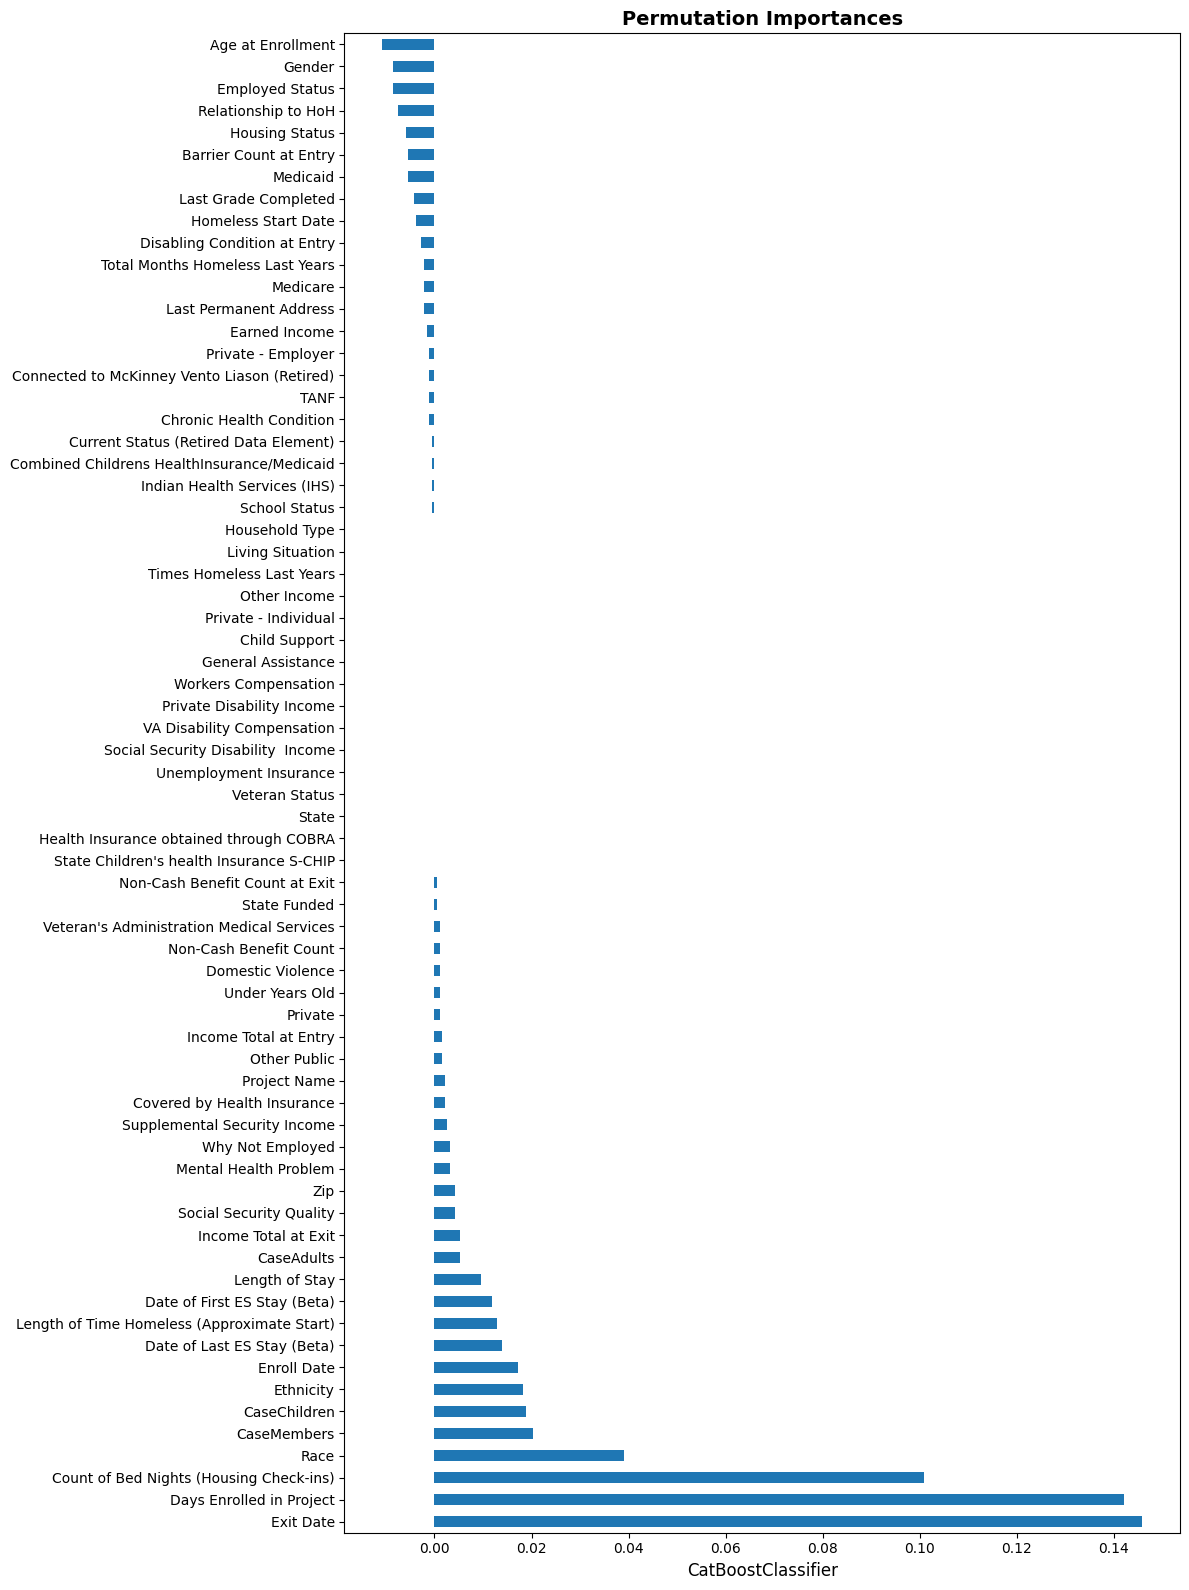

In [30]:
plt.subplots(figsize=(12,16))

cat_perm_imp.importances_mean.plot(kind='barh')

plt.title('Permutation Importances', fontsize=14, fontweight='bold')
plt.xlabel('CatBoostClassifier', fontsize=12)

plt.tight_layout()

#### `XGBoost`

In [31]:
xgb_perm_imp = permutation_importance(xgb_model, X_test, y_test, random_state=0)

In [32]:
data = {'importances_mean' : xgb_perm_imp['importances_mean'],
        'importances_std' : xgb_perm_imp['importances_std']}

xgb_perm_imp = pd.DataFrame(data, index=X.columns)
xgb_perm_imp.sort_values('importances_mean', ascending=False, inplace=True)

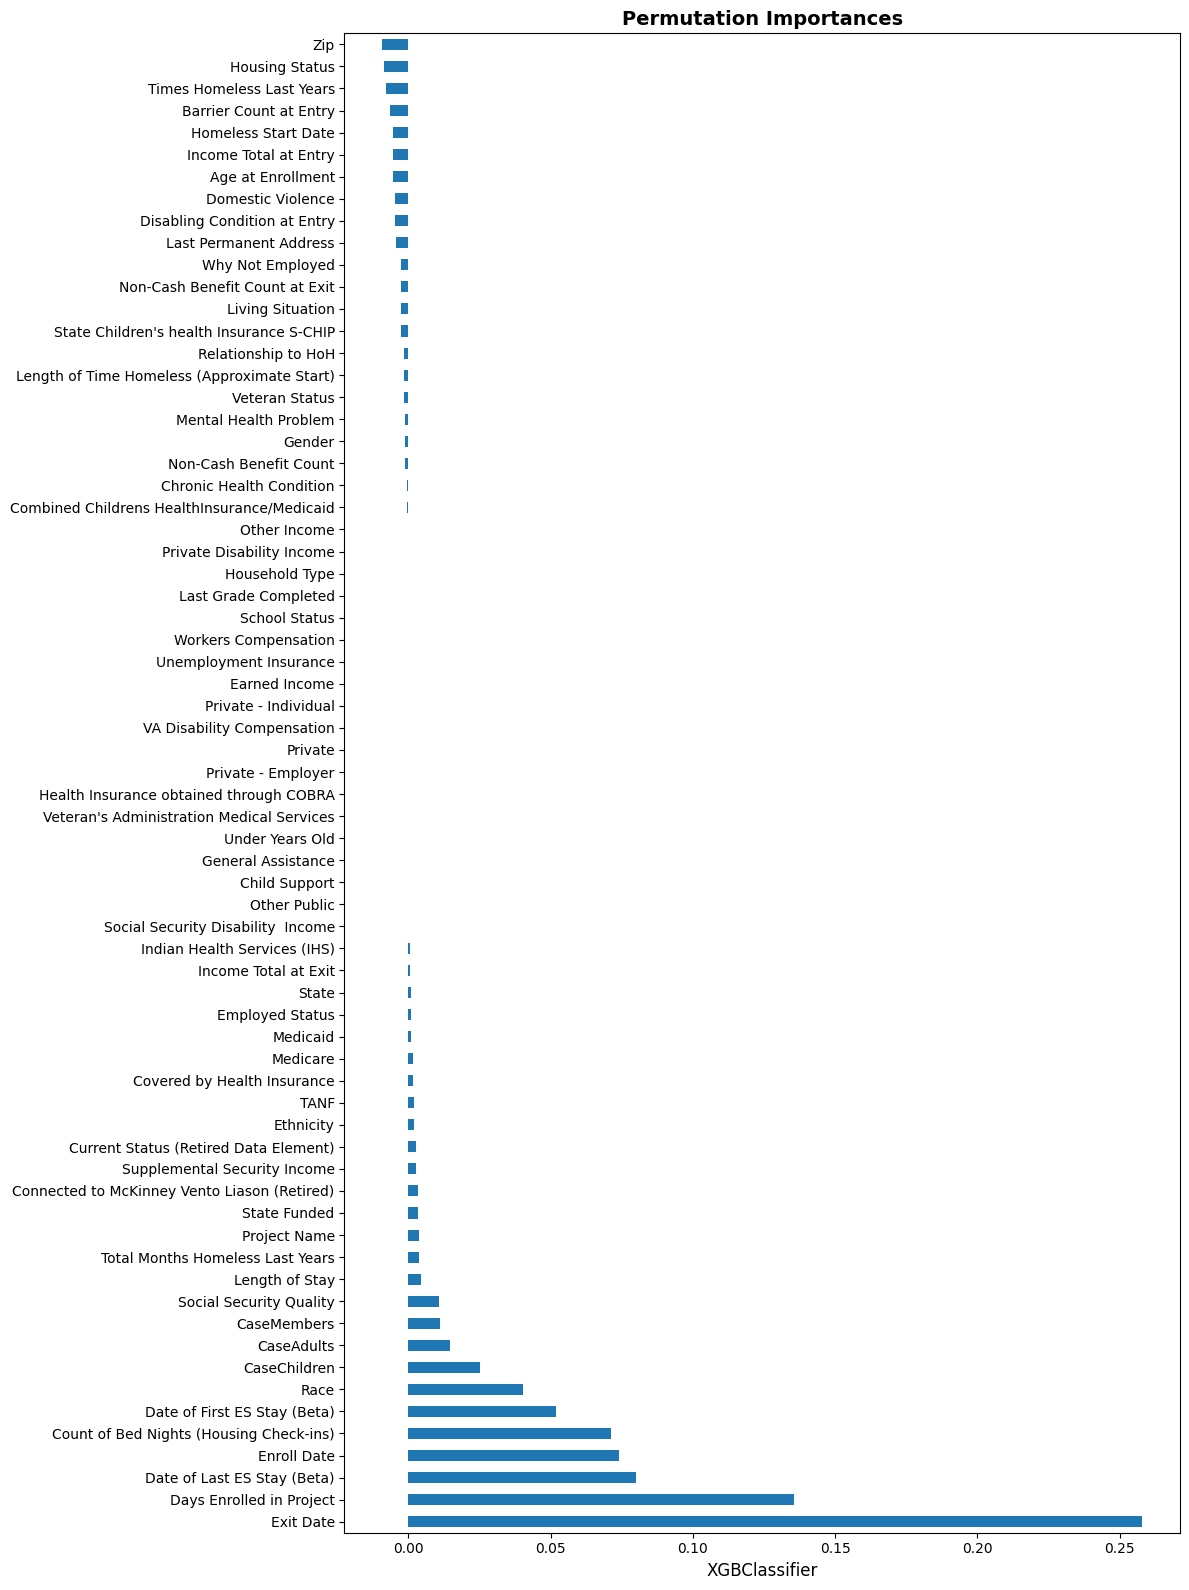

In [33]:
plt.subplots(figsize=(12,16))

xgb_perm_imp.importances_mean.plot(kind='barh')

plt.title('Permutation Importances', fontsize=14, fontweight='bold')
plt.xlabel('XGBClassifier', fontsize=12)

plt.tight_layout()

#### `RandomForest`

In [34]:
forest_perm_imp = permutation_importance(forest_model, X_test, y_test, random_state=0)

In [35]:
data = {'importances_mean' : forest_perm_imp['importances_mean'],
        'importances_std' : forest_perm_imp['importances_std']}

forest_perm_imp = pd.DataFrame(data, index=X.columns)
forest_perm_imp.sort_values('importances_mean', ascending=False, inplace=True)

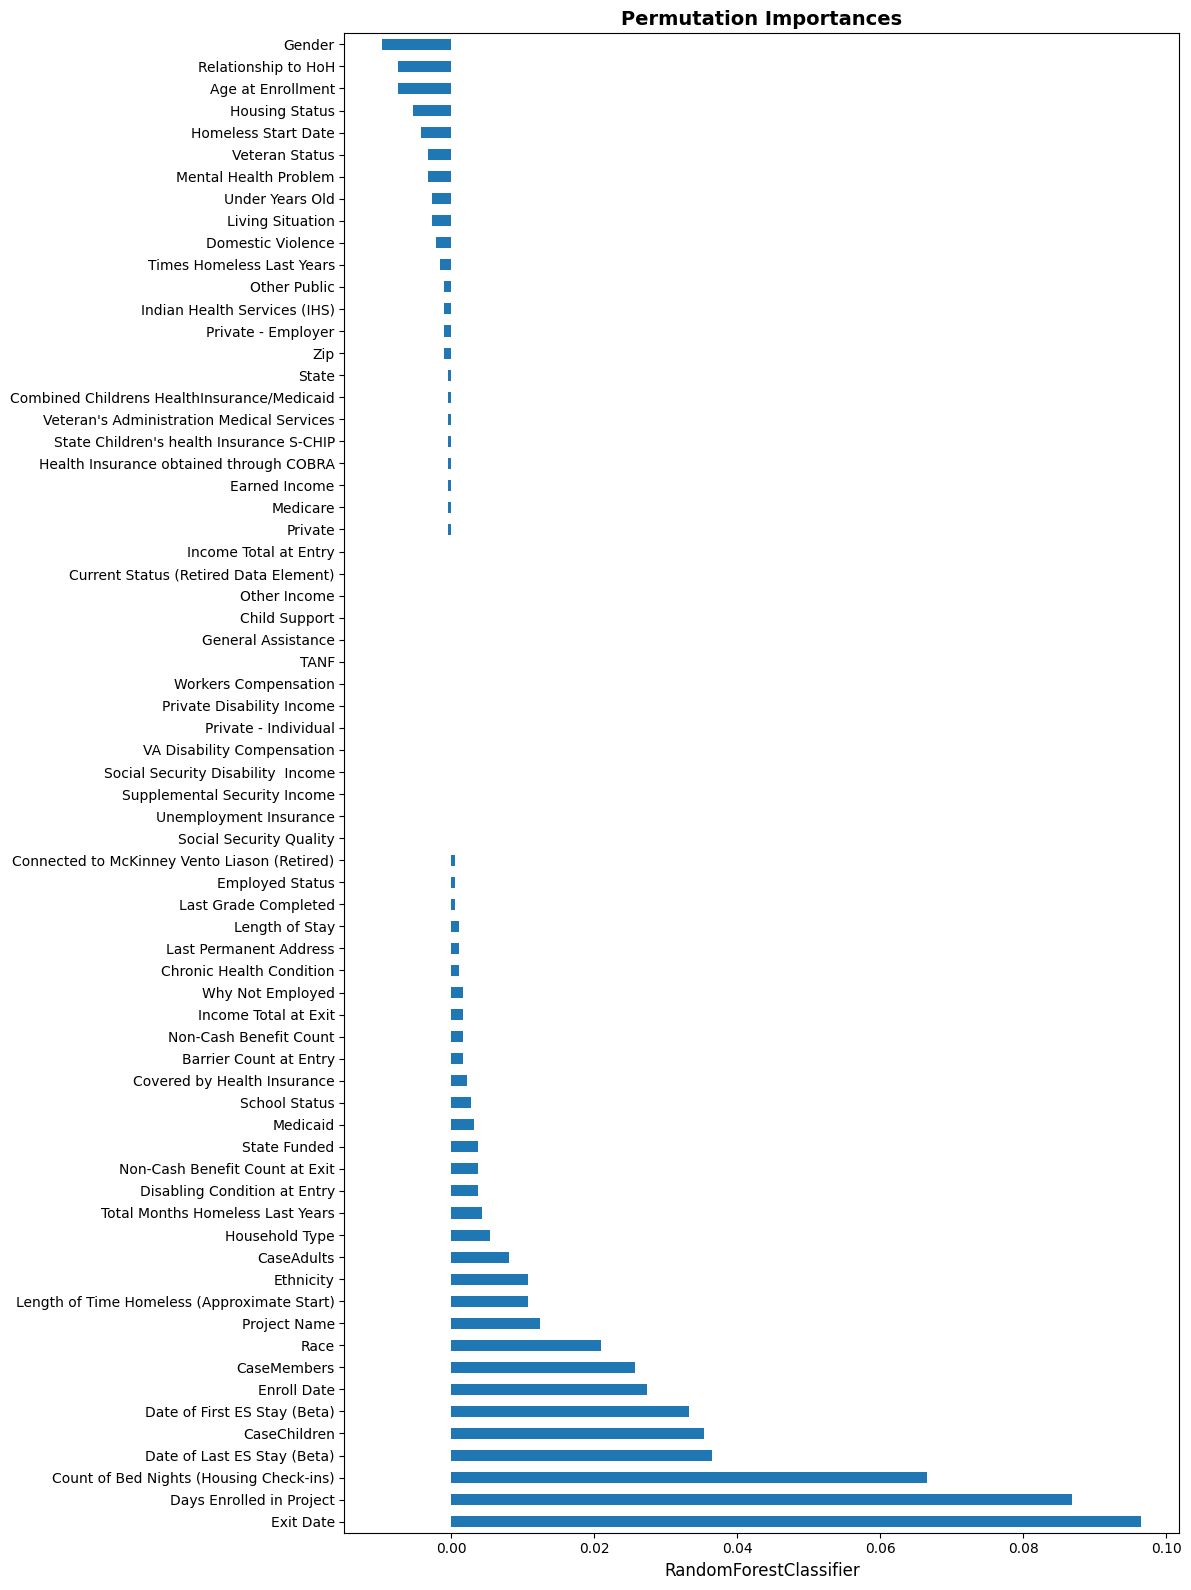

In [36]:
plt.subplots(figsize=(12,16))

forest_perm_imp.importances_mean.plot(kind='barh')

plt.title('Permutation Importances', fontsize=14, fontweight='bold')
plt.xlabel('RandomForestClassifier', fontsize=12)

plt.tight_layout()

## ELI5 Weights

#### `CatBoost`

In [37]:
show_weights(cat_model, feature_names=features, top=25)

Weight,Feature
0.1293,Days Enrolled in Project
0.1015,Count of Bed Nights (Housing Check-ins)
0.0970,Exit Date
0.0568,CaseMembers
0.0495,CaseChildren
0.0480,Date of Last ES Stay (Beta)
0.0473,Enroll Date
0.0467,Race
0.0340,Social Security Quality
0.0331,Age at Enrollment


#### `XGBoost`

In [38]:
show_weights(xgb_model, feature_names=features, top=25)

Weight,Feature
0.3114,Private
0.0738,Indian Health Services (IHS)
0.0532,Veteran's Administration Medical Services
0.0453,Project Name
0.0386,Other Income
0.0243,Ethnicity
0.0243,Supplemental Security Income
0.0193,Income Total at Exit
0.0183,Non-Cash Benefit Count
0.0178,Household Type


#### `RandomForest`

In [39]:
show_weights(forest_model, feature_names=features, top=25)

Weight,Feature
0.0852 ± 0.0522,Exit Date
0.0808 ± 0.0486,Days Enrolled in Project
0.0730 ± 0.0426,Count of Bed Nights (Housing Check-ins)
0.0667 ± 0.0426,Date of Last ES Stay (Beta)
0.0666 ± 0.0413,Enroll Date
0.0607 ± 0.0377,Date of First ES Stay (Beta)
0.0366 ± 0.0220,Age at Enrollment
0.0354 ± 0.0238,CaseMembers
0.0323 ± 0.0220,CaseChildren
0.0260 ± 0.0200,Length of Time Homeless (Approximate Start)


## Shap

In [40]:
# Setup for all models force plots
row = X.iloc[[99]]
row_p = processor.transform(row)

### `CatBoost`

#### `Force Plot`

In [41]:
explainer = shap.TreeExplainer(cat_model)

In [42]:
shap_values_p = explainer.shap_values(row_p)

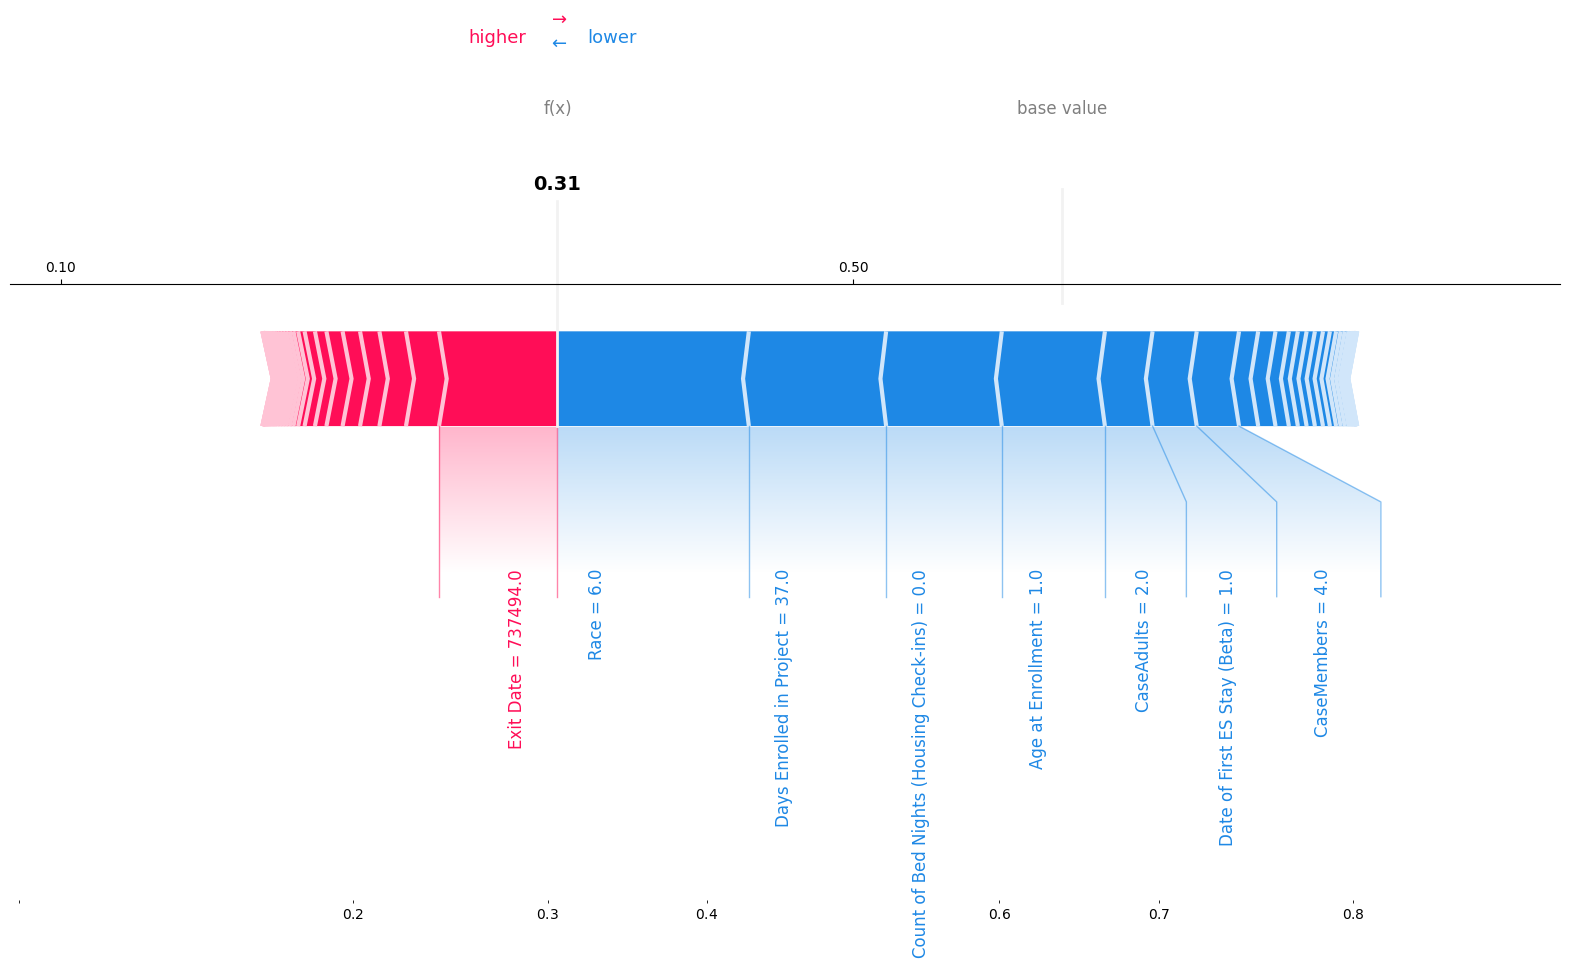

In [43]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values_p[0], 
    features=row_p,
    feature_names=column_names,
    link='logit'
    
).matplotlib(figsize=(20, 8), show=True, text_rotation=90);

#### `Summary Plot`

In [44]:
# Setup variable for all models
shap_values = explainer.shap_values(X_test)

2021-01-25 23:35:54.734 WARNING matplotlib.legend: No handles with labels found to put in legend.


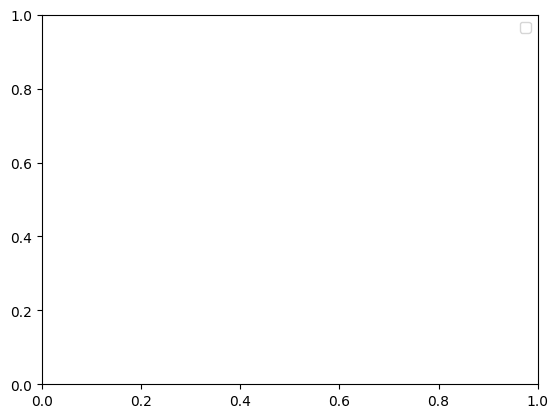

In [45]:
plt.legend()

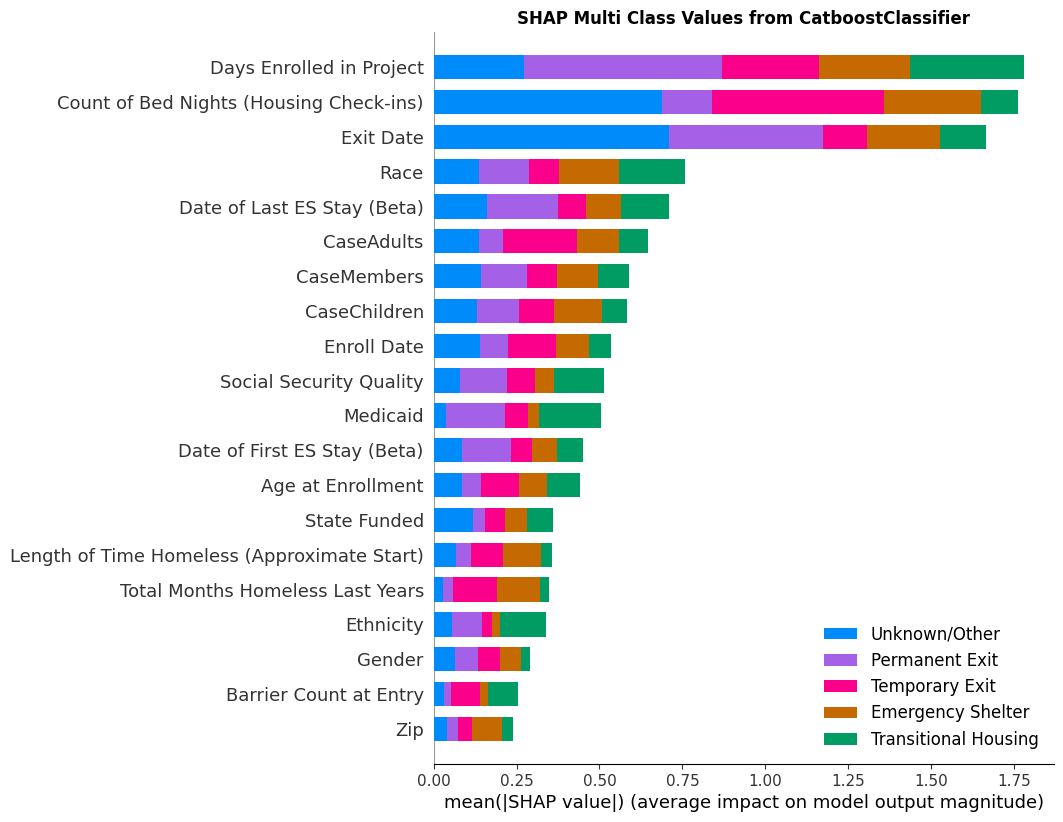

In [46]:
shap.summary_plot(shap_values, column_names, class_names=cat_model.classes_,
                  plot_type='bar', show=False, auto_size_plot=True)

plt.title('SHAP Multi Class Values from CatboostClassifier', fontsize=12, fontweight='bold')
plt.show()

### `XGBoost`

#### `Force Plot`

In [47]:
explainer = shap.TreeExplainer(xgb_model)
shap_values_p = explainer.shap_values(row_p)

In [48]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values_p[0], 
    features=row_p,
    feature_names=column_names,
    link='logit'
    
)

#### `Summary Plot`

In [49]:
explainer = shap.TreeExplainer(xgb_model)

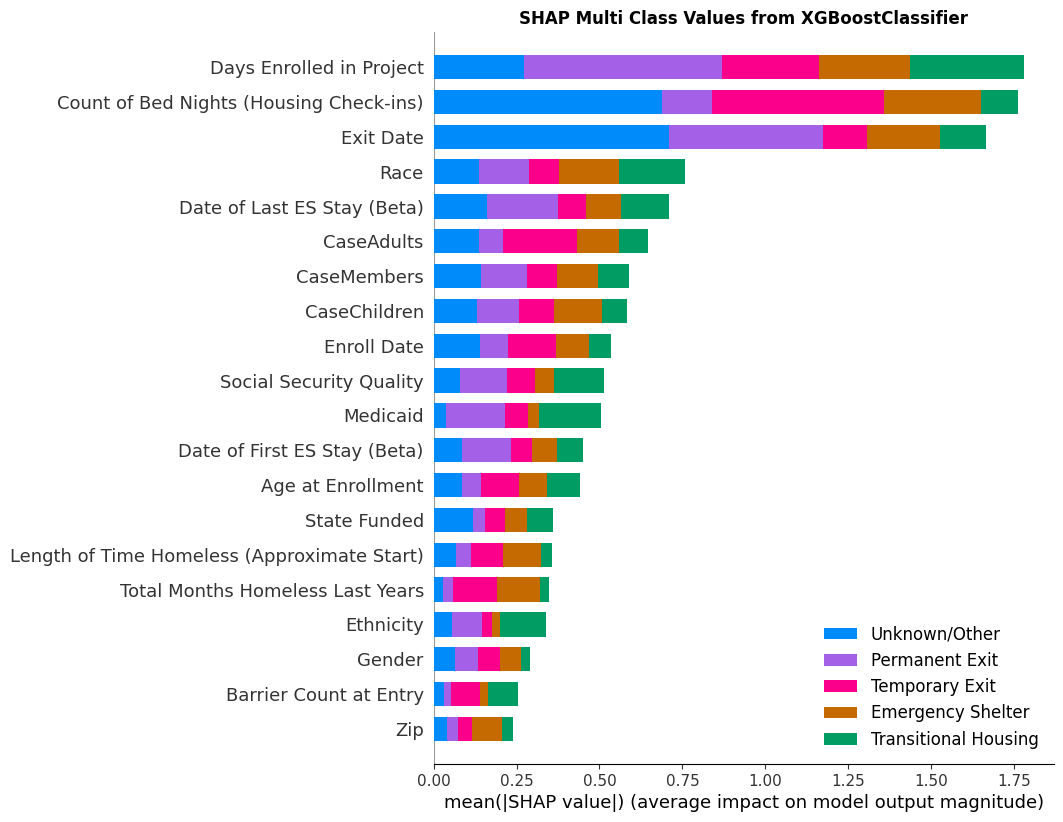

In [50]:
shap.summary_plot(shap_values, column_names, class_names=xgb_model.classes_,
                  plot_type='bar', show=False, auto_size_plot=True)

plt.title('SHAP Multi Class Values from XGBoostClassifier', fontsize=12, fontweight='bold')
plt.show()

### `RandomForest`

#### `Force Plot`

In [51]:
explainer = shap.TreeExplainer(forest_model)
shap_values_p = explainer.shap_values(row_p)

In [52]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values_p[0], 
    features=row_p,
    feature_names=column_names,
    link='logit'
    
)

#### `Summary Plot`

In [53]:
explainer = shap.TreeExplainer(forest_model)

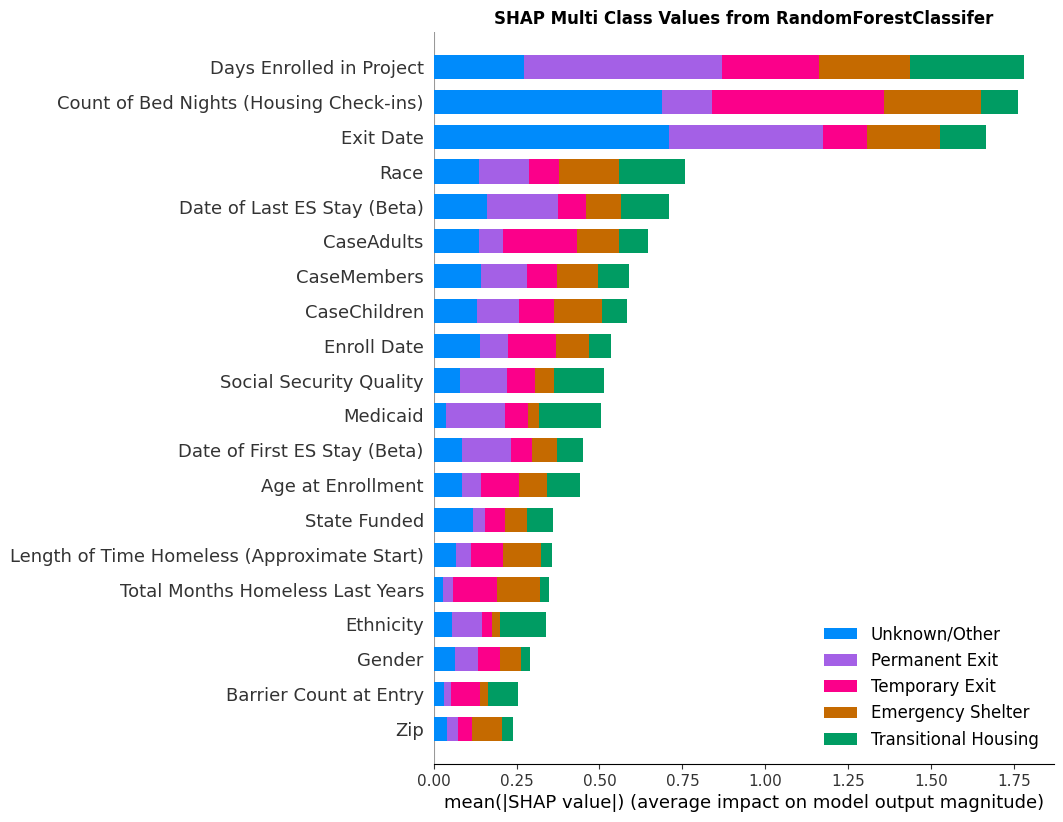

In [54]:
shap.summary_plot(shap_values, column_names, class_names=forest_model.classes_,
                  plot_type='bar', show=False, auto_size_plot=True)

plt.title('SHAP Multi Class Values from RandomForestClassifer', fontsize=12, fontweight='bold')
plt.show()

## Classification Reports

#### `CatBoost`

In [55]:
y_pred_c = cat_model.predict(X_test)
print(classification_report(y_test, y_pred_c))

                      precision    recall  f1-score   support

   Emergency Shelter       0.71      0.72      0.72        75
      Permanent Exit       0.75      0.73      0.74       124
      Temporary Exit       0.77      0.45      0.57        22
Transitional Housing       0.75      0.17      0.27        18
       Unknown/Other       0.72      0.85      0.78       134

            accuracy                           0.73       373
           macro avg       0.74      0.59      0.62       373
        weighted avg       0.73      0.73      0.72       373



#### `XGBoost`

In [56]:
y_pred_x = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_x))

                      precision    recall  f1-score   support

   Emergency Shelter       0.76      0.73      0.75        75
      Permanent Exit       0.85      0.81      0.83       124
      Temporary Exit       0.82      0.64      0.72        22
Transitional Housing       0.62      0.28      0.38        18
       Unknown/Other       0.79      0.93      0.86       134

            accuracy                           0.80       373
           macro avg       0.77      0.68      0.71       373
        weighted avg       0.80      0.80      0.79       373



#### `RandomForest`

In [57]:
y_pred_f = forest_model.predict(X_test)
print(classification_report(y_test, y_pred_f))

                      precision    recall  f1-score   support

   Emergency Shelter       0.81      0.69      0.75        75
      Permanent Exit       0.78      0.77      0.78       124
      Temporary Exit       1.00      0.41      0.58        22
Transitional Housing       0.80      0.22      0.35        18
       Unknown/Other       0.72      0.93      0.81       134

            accuracy                           0.76       373
           macro avg       0.82      0.60      0.65       373
        weighted avg       0.78      0.76      0.75       373



## Confusion Matrices

#### `CatBoost`

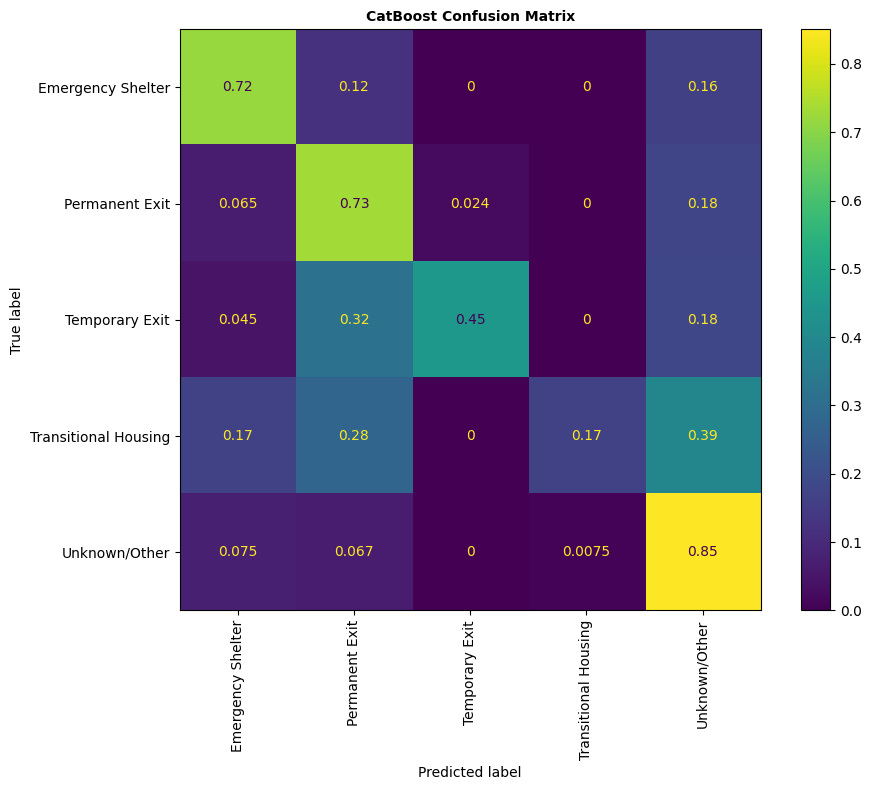

In [58]:
fig, ax1 = plt.subplots(figsize=(10,8))

plot_confusion_matrix(cat_model, X_test, y_test, 
                      normalize='true', xticks_rotation='vertical', ax=ax1)

ax1.set_title('CatBoost Confusion Matrix', fontsize=10, fontweight='bold')
ax1.grid(False)
plt.tight_layout()

#### `XGBoost`

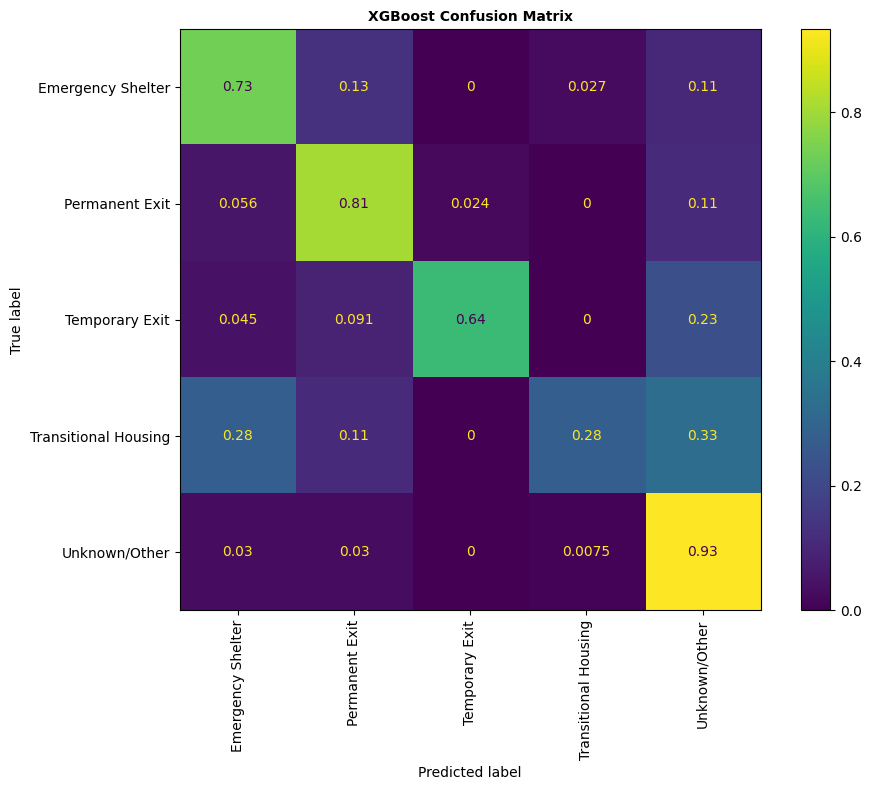

In [59]:
fig, ax2 = plt.subplots(figsize=(10,8))

plot_confusion_matrix(xgb_model, X_test, y_test, 
                      normalize='true', xticks_rotation='vertical', ax=ax2)

ax2.set_title('XGBoost Confusion Matrix', fontsize=10, fontweight='bold')
ax2.grid(False)
plt.tight_layout()

#### `RandomForest`

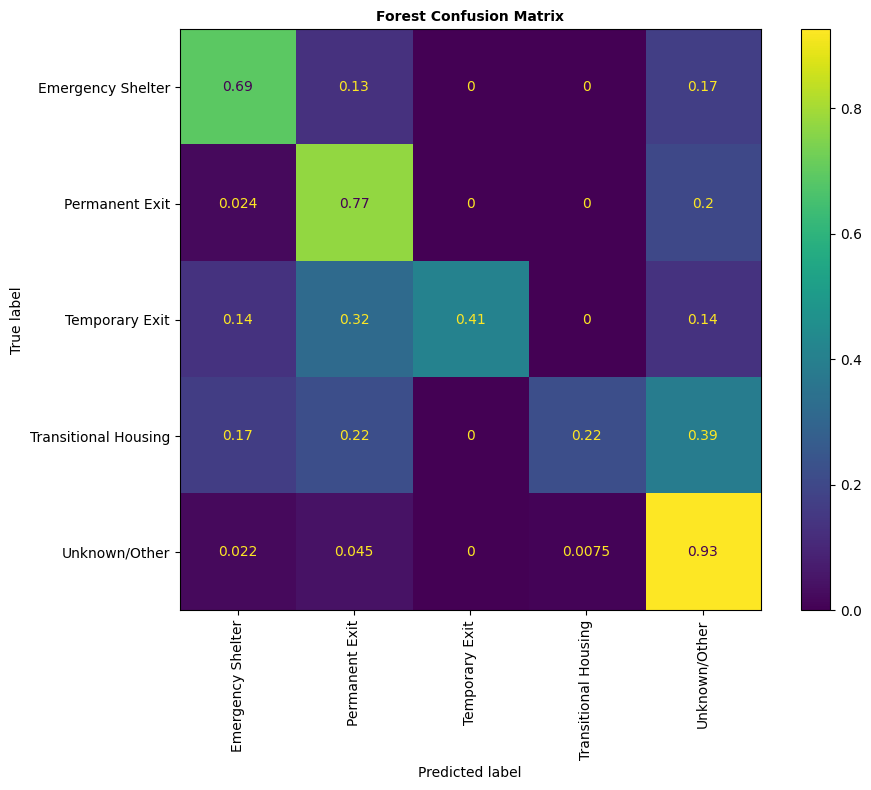

In [60]:
fig, ax3 = plt.subplots(figsize=(10,8))

plot_confusion_matrix(forest_model, X_test, y_test, 
                      normalize='true', xticks_rotation='vertical', ax=ax3)

ax3.set_title('Forest Confusion Matrix', fontsize=10, fontweight='bold')
ax3.grid(False)
plt.tight_layout()

## PDP Features Plot

In [62]:
X_pdp = pd.DataFrame(X_train, columns=column_names)

#### `Catboost`

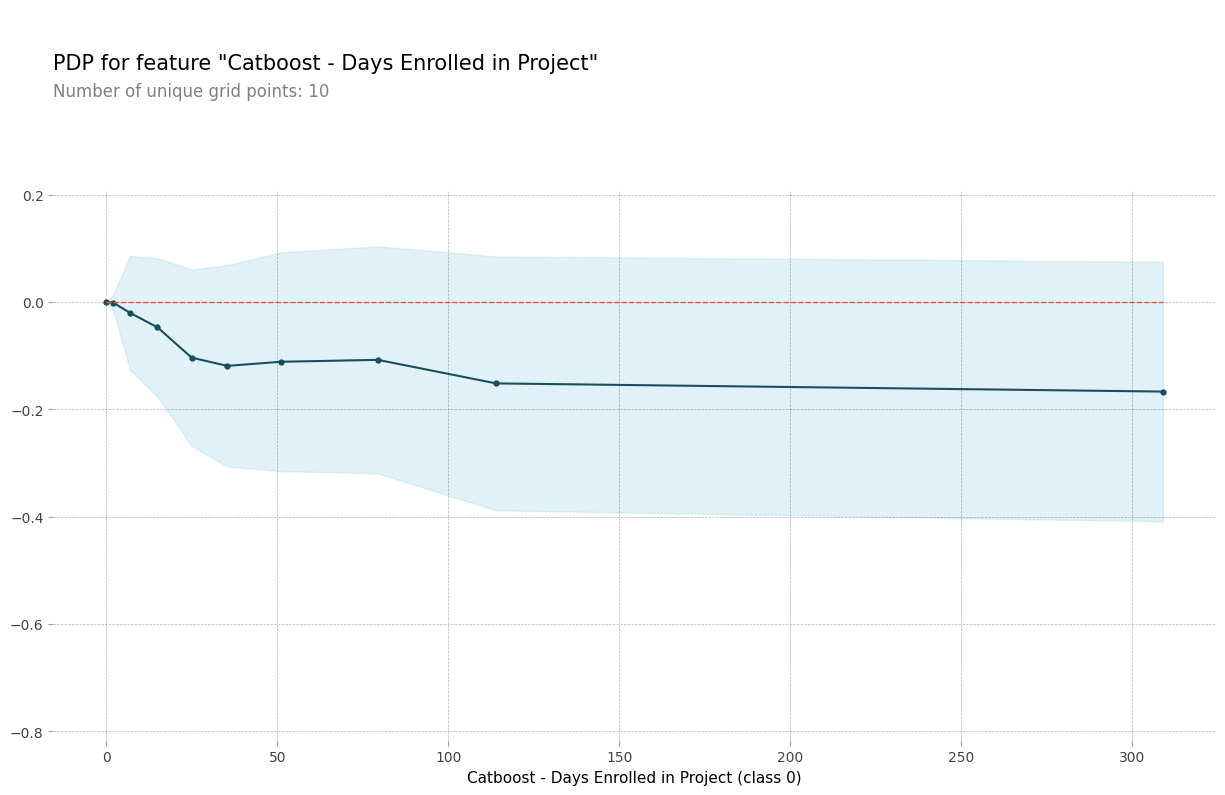

In [66]:
feature = 'Days Enrolled in Project'
feature_name = 'Catboost - Days Enrolled in Project'

isolated = pdp_isolate(
    model=cat_model,
    dataset=X_pdp,
    model_features=X_pdp.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated[0], feature_name=feature_name)
plt.tight_layout()
plt.show();

#### `XGBoost`

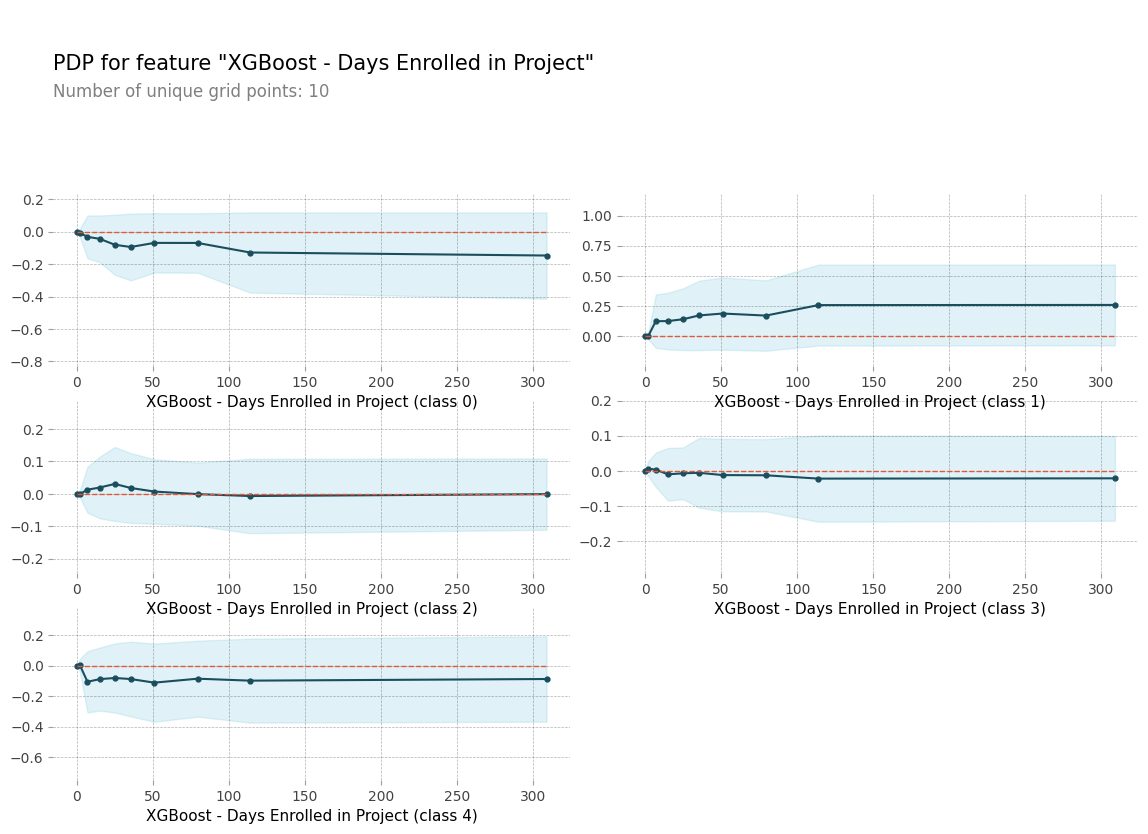

In [64]:
feature = 'Days Enrolled in Project'
feature_name = 'XGBoost - Days Enrolled in Project'

isolated = pdp_isolate(
    model=xgb_model,
    dataset=X_pdp,
    model_features=X_pdp.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated, feature_name=feature_name, figsize=(14,10))
plt.tight_layout()
plt.show();

#### `RandomForest`

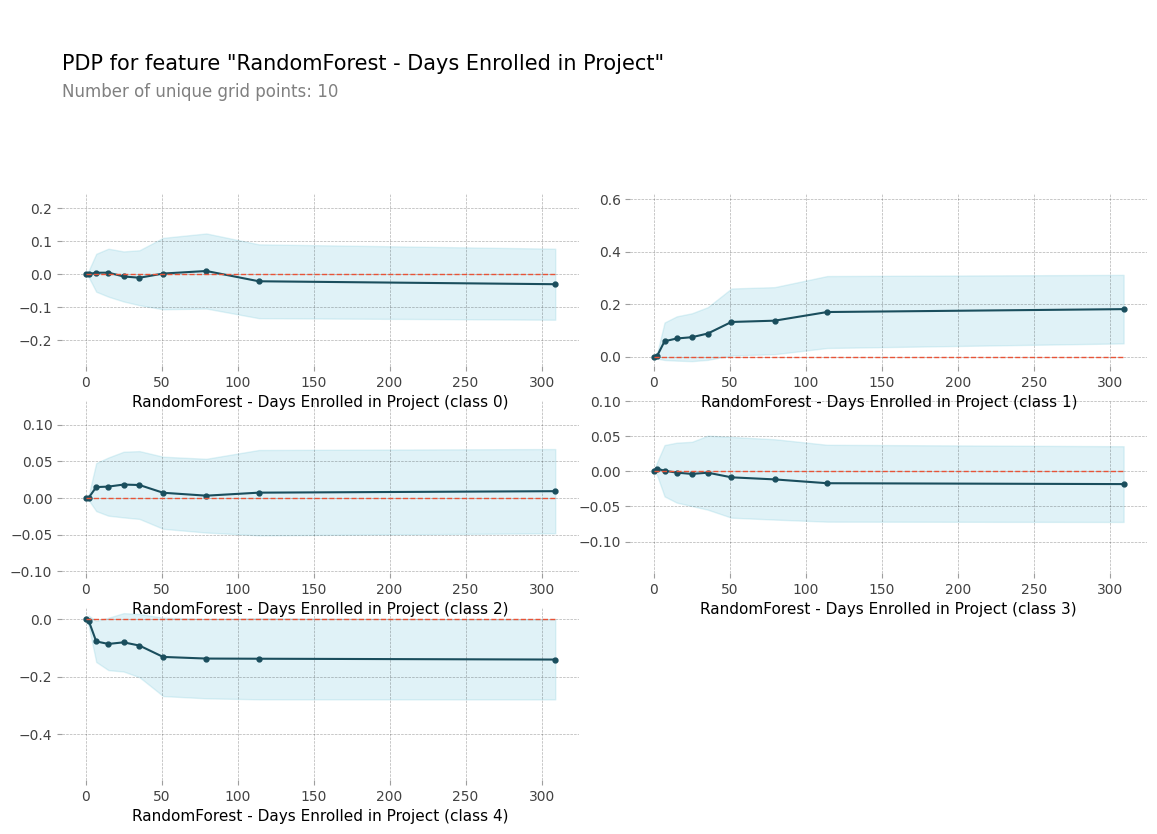

In [65]:
feature = 'Days Enrolled in Project'
feature_name = 'RandomForest - Days Enrolled in Project'

isolated = pdp_isolate(
    model=forest_model,
    dataset=X_pdp,
    model_features=X_pdp.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated, feature_name=feature_name, figsize=(14,10))
plt.tight_layout()
plt.show();